In [53]:
import shap
import polars as pl
import pandas as pd
import logging
import numpy as np
from joblib import load
import argparse
import logging
import os
import plotnine

In [54]:
# Read training data
# Read training data, adapted from 11_generate_models.py
class Args:
    training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
    y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
    model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv.models/XGBoost.model"

args = Args()

# Read y
y0 = pl.read_csv(args.y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
logging.info("Read y: %s", y1.shape)
# Log counts of each class
logging.info("Counts of each class amongst unique accessions: %s", y1.groupby("oxytolerance").agg(pl.count()))

# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
logging.info("Read in {} GTDB reps".format(len(gtdb)))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

# Read training data
d = pl.read_csv(args.training_file,separator="\t")
logging.info("Read training data: %s", d.shape)

# Ignore all but training data
d2 = d.join(gtdb.select(['accession','phylum','class','order','family','genus']), on="accession", how="left")
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
logging.info("Counts of each class in training/test data: %s", d3.groupby("oxytolerance").agg(pl.count()))

X = d3.select(pl.exclude(['accession','oxytolerance','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
# Map oxytolerance to 0, 1, 2
if 'anaerobic_with_respiration_genes' in d3['oxytolerance'].to_list():
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
        'anaerobic_with_respiration_genes': 2,
    }
else:
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
    }

y = d3.select(pl.col('oxytolerance').apply(lambda x: classes_map[x]).alias('oxytolerance'))
logging.info("Counts of y: %s", y.groupby("oxytolerance").agg(pl.count()))
y = y.to_pandas()

groups = d3['family'].to_list()

d_gtdb = d3.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

In [55]:
model = load(args.model)
model

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=64, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Load KEGG names

In [56]:
modal_keggs = pd.read_csv('data/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
# modal_keggs

In [57]:
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X.columns,'cog'], modal_keggs.loc[X.columns,'ko'], modal_keggs.loc[X.columns,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
# for 
# X_pred_scaled
# Ensure column names are unique
# and don't contain  [, ] or <
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [58]:
pred = model.predict(X)

In [59]:
pd.Series(pred).value_counts()

1    58376
0    29788
Name: count, dtype: int64

In [60]:
explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(X), columns=X.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


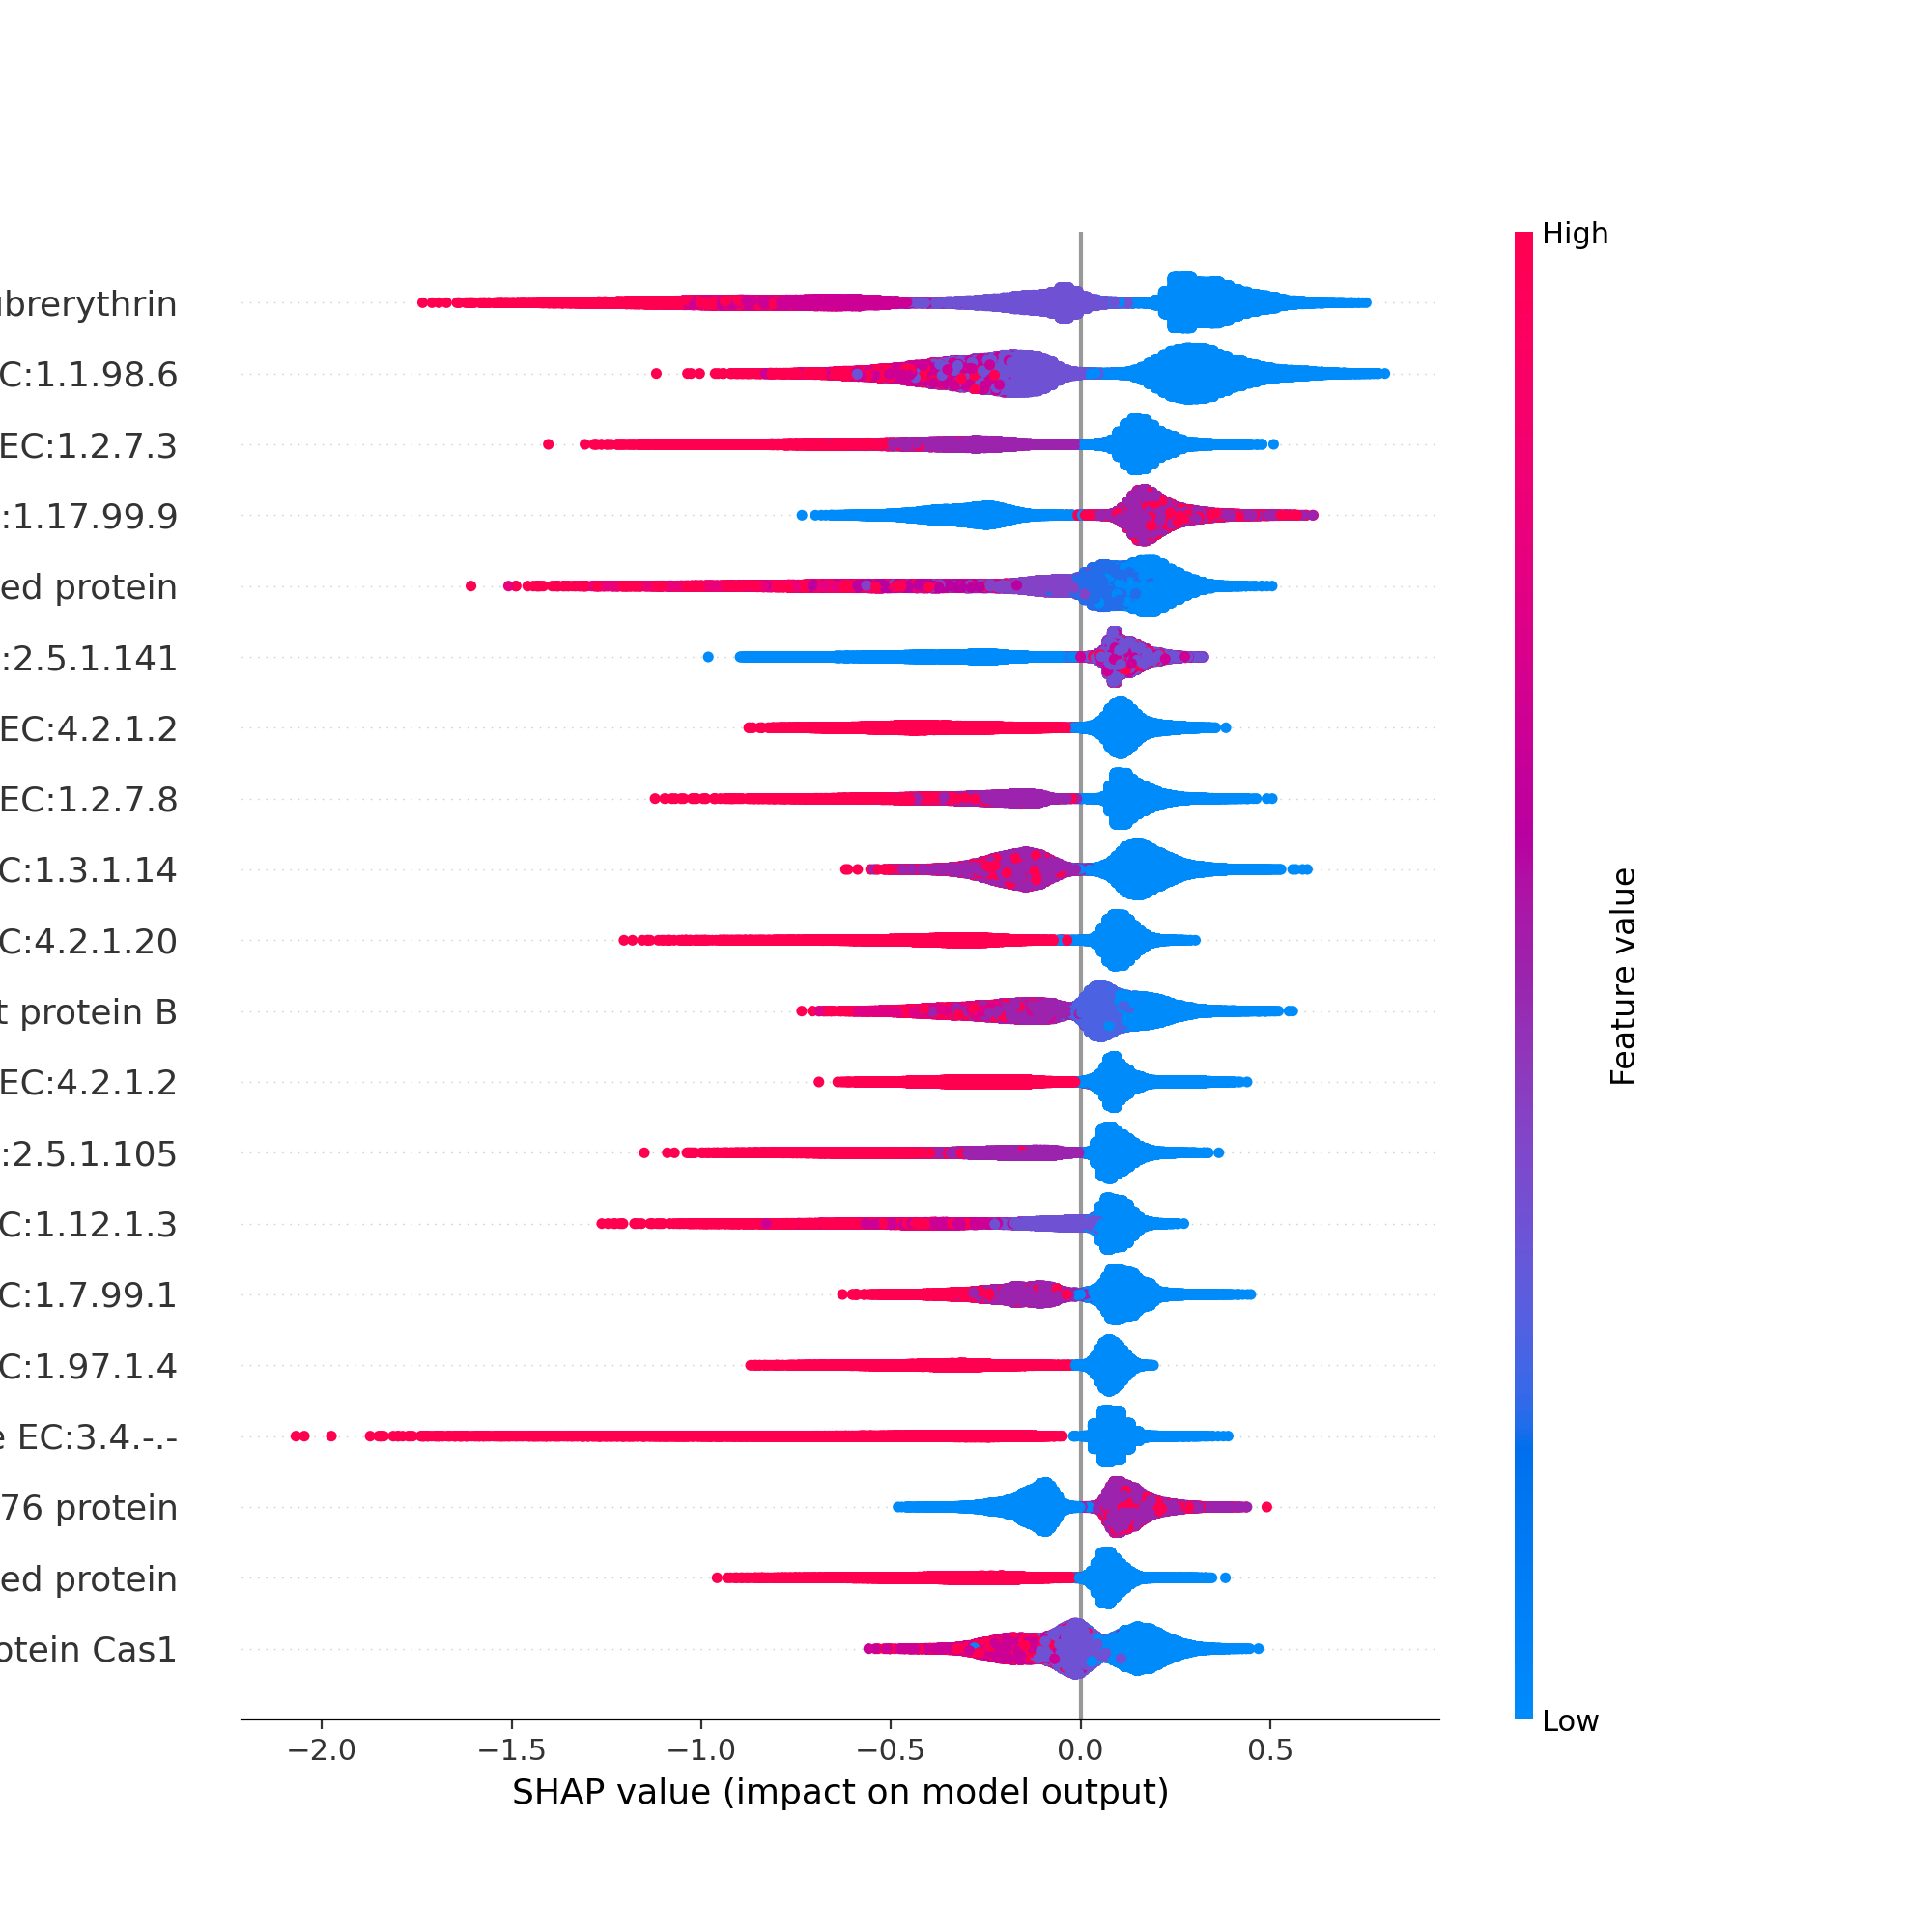

In [61]:
from matplotlib import pyplot as plt
plt.close()
shap.summary_plot(shap_values, X_pred_scaled, plot_size=(10,10))

# Copy numbers amongst leaves

In [62]:
# Read training data
# Read training data, adapted from 11_generate_models.py
class Args:
    training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
    y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
    model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv.models/XGBoost.model"
    target_levels = ['anaerobe', 'aerobe']

args = Args()

# Read y
y0 = pl.read_csv(args.y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
logging.info("Read y: %s", y1.shape)
# Log counts of each class
logging.info("Counts of each class amongst unique accessions: %s", y1.groupby("oxytolerance").agg(pl.count()))

# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
logging.info("Read in {} GTDB reps".format(len(gtdb)))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

# Read training data
d = pl.read_csv(args.training_file,separator="\t")
logging.info("Read training data: %s", d.shape)

# Ignore all but training data
d2 = d.join(gtdb.select(['accession','phylum','class','order','family','genus']), on="accession", how="left")
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
logging.info("Counts of each class in training/test data: %s", d3.groupby("oxytolerance").agg(pl.count()))

d3_original =d3.filter(
    pl.all(pl.col("false_negative_rate")==0, pl.col("false_positive_rate")==0)
)
target_column = 'oxytolerance'
X_original = d3_original.select(pl.exclude(['accession',target_column,'phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()

# Map oxytolerance to 0, 1, 2
if args.target_levels:
    classes_map = {k: i for i, k in enumerate(args.target_levels)}
else:
    if 'anaerobic_with_respiration_genes' in d3['oxytolerance'].to_list():
        classes_map = {
            'anaerobe': 0,
            'aerobe': 1,
            'anaerobic_with_respiration_genes': 2,
        }
    else:
        classes_map = {
            'anaerobe': 0,
            'aerobe': 1,
        }

y_original = d3_original.select(pl.col(target_column).apply(lambda x: classes_map[x]).alias(target_column))
logging.info("Counts of y: %s", y_original.groupby(target_column).agg(pl.count()))
y_original = y_original.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X_original = X_original.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

In [63]:
# For the top 20 features i.e. those with highest absolute mean SHAP value, what is the copy number in each of the classes?
top20 = list(reversed(np.argsort(np.abs(shap_values).mean(0))[-20:]))

top20_names = X_pred_scaled.columns[top20]

no_yes = y_original[y_original.columns[0]].values
top20_pred0 = X_original.iloc[[v==0 for v in no_yes],top20]
top20_pred1 = X_original.iloc[[v==1 for v in no_yes],top20]

top20_names

Index(['COG1592 K19824 rubrerythrin',
       'COG1328 K21636 ribonucleoside-triphosphate reductase (formate) EC:1.1.98.6',
       'COG1014 K00177 2-oxoglutarate ferredoxin oxidoreductase subunit gamma EC:1.2.7.3',
       'COG1612 K02259 heme a synthase EC:1.17.99.9',
       'COG1373 K07133 uncharacterized protein',
       'COG0109 K02257 heme o synthase EC:2.5.1.141',
       'COG1838 K01678 fumarate hydratase subunit beta EC:4.2.1.2',
       'COG4231 K00179 indolepyruvate ferredoxin oxidoreductase, alpha subunit EC:1.2.7.8',
       'COG0167 K17828 dihydroorotate dehydrogenase (NAD+) catalytic subunit EC:1.3.1.14',
       'COG1350 K06001 tryptophan synthase beta chain EC:4.2.1.20',
       'COG0370 K04759 ferrous iron transport protein B',
       'COG1951 K01677 fumarate hydratase subunit alpha EC:4.2.1.2',
       'COG1237 K06897 7,8-dihydropterin-6-yl-methyl-4-(beta-D-ribofuranosyl)aminobenzene 5'-phosphate synthase EC:2.5.1.105',
       'COG4624 K18332 NADP-reducing hydrogenase subunit

In [64]:
top20_pred0_value_counts = None
top20_pred1_value_counts = None

# for each column of top20_pred0, count the number of times each value occurs
for i in range(top20_pred0.shape[1]):
    top20_pred0_value_counts = pd.concat([top20_pred0_value_counts, top20_pred0.iloc[:,i].value_counts()], axis=1)
    top20_pred1_value_counts = pd.concat([top20_pred1_value_counts, top20_pred1.iloc[:,i].value_counts()], axis=1)

top20_pred0_value_counts.columns = top20_names
top20_pred1_value_counts.columns = top20_names

# For any values > 2, set to 2
# print(top20_pred0_value_counts.iloc[:4,:3])
# Set the 3rd row to be the sum of all values in rows 3 and above
top20_pred0_value_counts.iloc[2,:] = top20_pred0_value_counts.iloc[2:,:].sum(axis=0)
top20_pred0_value_counts = top20_pred0_value_counts.iloc[:3,:]
# print(top20_pred0_value_counts.iloc[:4,:3])

top20_pred1_value_counts.iloc[2,:] = top20_pred1_value_counts.iloc[2:,:].sum(axis=0)
top20_pred1_value_counts = top20_pred1_value_counts.loc[[0,1,2],:]
top20_pred1_value_counts

,COG1592 K19824 rubrerythrin,COG1328 K21636 ribonucleoside-triphosphate reductase (formate) EC:1.1.98.6,COG1014 K00177 2-oxoglutarate ferredoxin oxidoreductase subunit gamma EC:1.2.7.3,COG1612 K02259 heme a synthase EC:1.17.99.9,COG1373 K07133 uncharacterized protein,COG0109 K02257 heme o synthase EC:2.5.1.141,COG1838 K01678 fumarate hydratase subunit beta EC:4.2.1.2,"COG4231 K00179 indolepyruvate ferredoxin oxidoreductase, alpha subunit EC:1.2.7.8",COG0167 K17828 dihydroorotate dehydrogenase (NAD+) catalytic subunit EC:1.3.1.14,COG1350 K06001 tryptophan synthase beta chain EC:4.2.1.20,COG0370 K04759 ferrous iron transport protein B,COG1951 K01677 fumarate hydratase subunit alpha EC:4.2.1.2,"COG1237 K06897 7,8-dihydropterin-6-yl-methyl-4-(beta-D-ribofuranosyl)aminobenzene 5'-phosphate synthase EC:2.5.1.105",COG4624 K18332 NADP-reducing hydrogenase subunit HndD EC:1.12.1.3,COG0369 K05601 hydroxylamine reductase EC:1.7.99.1,COG1313 K04070 putative pyruvate formate lyase activating enzyme EC:1.97.1.4,COG4690 K08659 dipeptidase EC:3.4.-.-,COG1054 K07146 UPF0176 protein,COG1342 K06933 uncharacterized protein,COG1518 K15342 CRISP-associated protein Cas1
0,1523.0,1372.0,1605.0,209.0,1329.0,48.0,1592.0,1539.0,1328.0,1516.0,837.0,1586.0,1531.0,1616.0,1459.0,1608.0,1579.0,516.0,1596.0,1062.0
1,94.0,183.0,16.0,1367.0,170.0,1416.0,27.0,77.0,280.0,100.0,687.0,30.0,83.0,4.0,157.0,13.0,32.0,1082.0,23.0,386.0
2,4.0,66.0,0.0,45.0,122.0,157.0,2.0,5.0,13.0,5.0,97.0,5.0,7.0,1.0,5.0,0.0,10.0,23.0,2.0,173.0


In [65]:
# Combine the two dataframes
top20_value_counts = pd.concat([top20_pred0_value_counts, top20_pred1_value_counts], axis=0)
top20_value_counts['class'] = [args.target_levels[0]]*3 + [args.target_levels[1]]*3
top20_value_counts['copy_number'] = list(top20_value_counts.index)
top20_value_counts

,COG1592 K19824 rubrerythrin,COG1328 K21636 ribonucleoside-triphosphate reductase (formate) EC:1.1.98.6,COG1014 K00177 2-oxoglutarate ferredoxin oxidoreductase subunit gamma EC:1.2.7.3,COG1612 K02259 heme a synthase EC:1.17.99.9,COG1373 K07133 uncharacterized protein,COG0109 K02257 heme o synthase EC:2.5.1.141,COG1838 K01678 fumarate hydratase subunit beta EC:4.2.1.2,"COG4231 K00179 indolepyruvate ferredoxin oxidoreductase, alpha subunit EC:1.2.7.8",COG0167 K17828 dihydroorotate dehydrogenase (NAD+) catalytic subunit EC:1.3.1.14,COG1350 K06001 tryptophan synthase beta chain EC:4.2.1.20,...,"COG1237 K06897 7,8-dihydropterin-6-yl-methyl-4-(beta-D-ribofuranosyl)aminobenzene 5'-phosphate synthase EC:2.5.1.105",COG4624 K18332 NADP-reducing hydrogenase subunit HndD EC:1.12.1.3,COG0369 K05601 hydroxylamine reductase EC:1.7.99.1,COG1313 K04070 putative pyruvate formate lyase activating enzyme EC:1.97.1.4,COG4690 K08659 dipeptidase EC:3.4.-.-,COG1054 K07146 UPF0176 protein,COG1342 K06933 uncharacterized protein,COG1518 K15342 CRISP-associated protein Cas1,class,copy_number
1,261.0,432.0,295.0,48.0,159.0,121.0,402.0,313.0,687.0,362.0,...,302.0,105.0,446.0,335.0,120.0,28.0,308.0,340.0,anaerobe,1
2,247.0,208.0,154.0,4.0,80.0,7.0,68.0,169.0,13.0,19.0,...,88.0,96.0,91.0,43.0,29.0,1.0,93.0,197.0,anaerobe,2
0,320.0,188.0,379.0,776.0,589.0,700.0,358.0,346.0,128.0,447.0,...,438.0,627.0,291.0,450.0,679.0,799.0,427.0,291.0,anaerobe,0
0,1523.0,1372.0,1605.0,209.0,1329.0,48.0,1592.0,1539.0,1328.0,1516.0,...,1531.0,1616.0,1459.0,1608.0,1579.0,516.0,1596.0,1062.0,aerobe,0
1,94.0,183.0,16.0,1367.0,170.0,1416.0,27.0,77.0,280.0,100.0,...,83.0,4.0,157.0,13.0,32.0,1082.0,23.0,386.0,aerobe,1
2,4.0,66.0,0.0,45.0,122.0,157.0,2.0,5.0,13.0,5.0,...,7.0,1.0,5.0,0.0,10.0,23.0,2.0,173.0,aerobe,2


In [66]:
# Convert to polars and then melt
top20_value_counts_pl = pl.DataFrame(top20_value_counts)
top20_copy_numbers = top20_value_counts_pl.melt(id_vars=['class','copy_number'], variable_name='feature', value_name='count')
top20_copy_numbers[:3]

class,copy_number,feature,count
str,i64,str,f64
"""anaerobe""",1,"""COG1592 K19824…",261.0
"""anaerobe""",2,"""COG1592 K19824…",247.0
"""anaerobe""",0,"""COG1592 K19824…",320.0


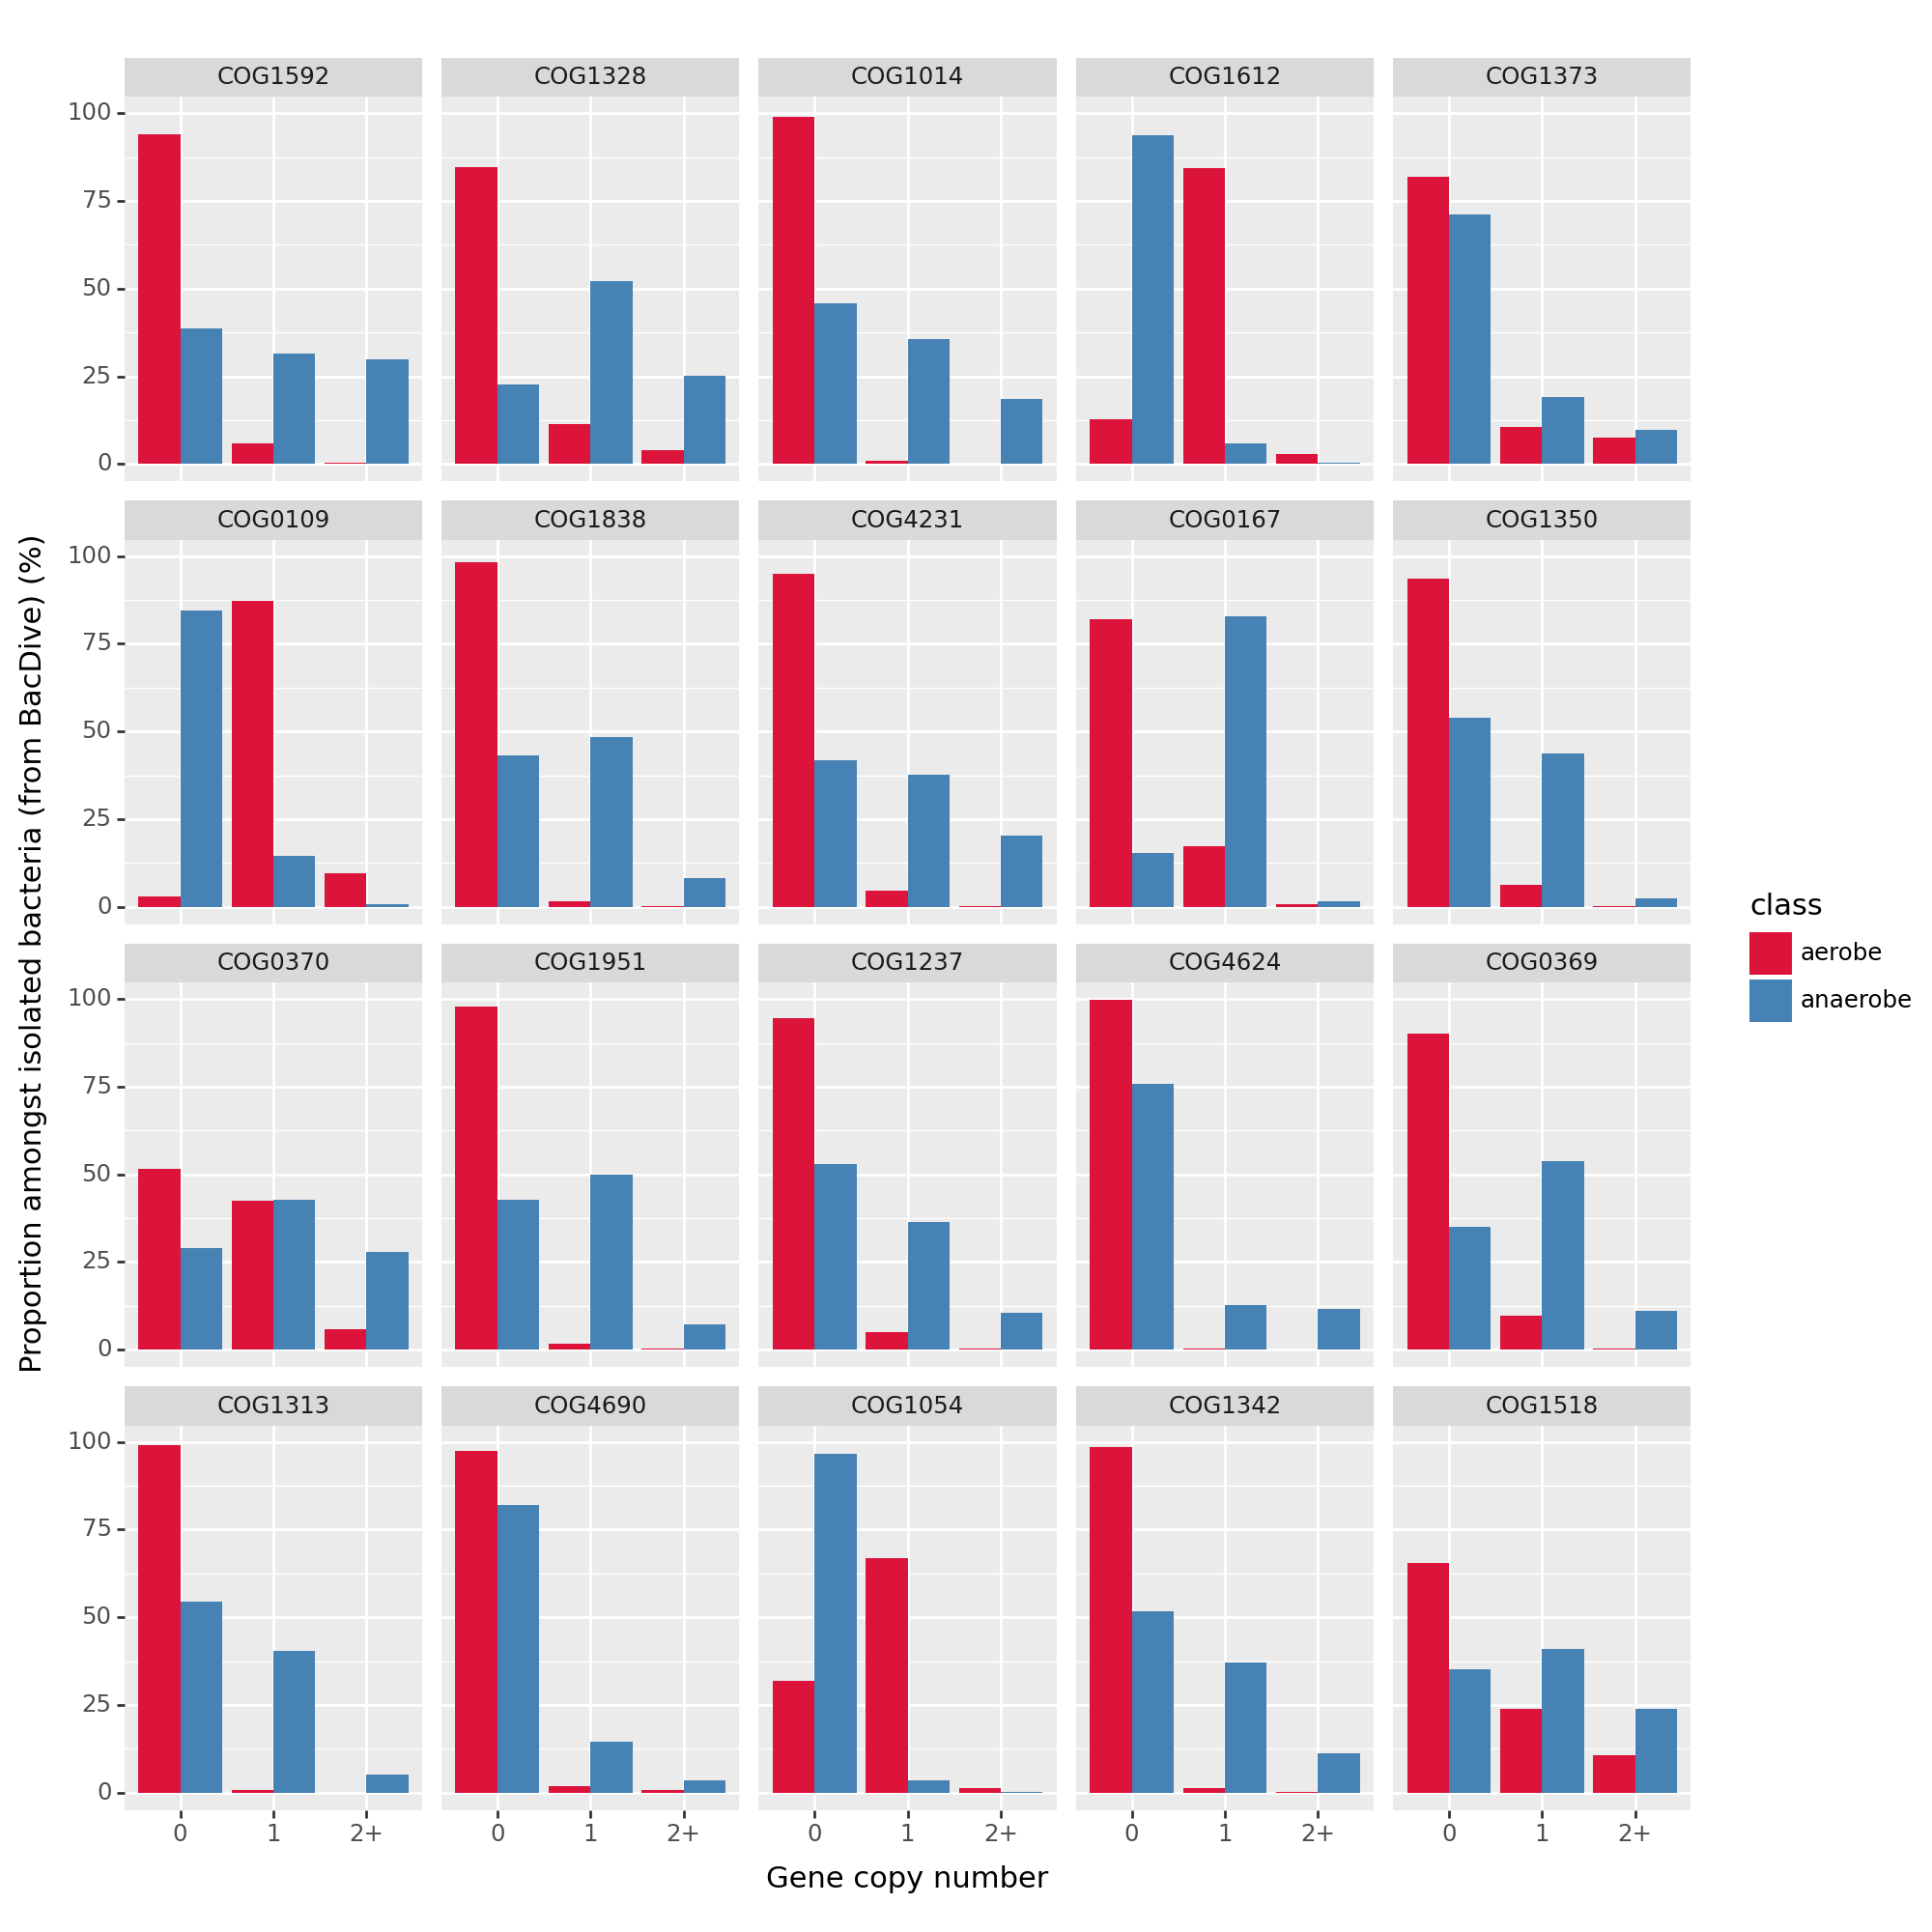

In [67]:
from plotnine import ggplot, aes, geom_col, facet_wrap, position_dodge, scale_x_discrete, scale_x_continuous, labs, scale_fill_manual

# set image size to 20 by 21
plotnine.options.figure_size = (10, 10)

top20_copy_numbers_cat = top20_copy_numbers.select(
    [pl.col('feature').str.split(' ').list.get(0).cast(pl.Categorical).alias('feature'), 
    pl.exclude('feature')]
)

# Normalise the counts
top20_copy_numbers_cat = top20_copy_numbers_cat.select([
    pl.col('count').fill_null(pl.lit(0)).alias('count'),
    pl.exclude('count')
])
top20_copy_numbers_cat = top20_copy_numbers_cat.groupby(['feature','class']).apply(lambda x: x.select([pl.exclude('count'), pl.col('count').alias('percent') / sum(x['count']) * 100]))

top20_copy_numbers_cat = top20_copy_numbers_cat.sort('copy_number').with_columns(pl.col('copy_number').str.replace('2','2+').cast(pl.Categorical()).alias('copy_number_name'))

# plot the copy numbers in plotnine
print(ggplot(top20_copy_numbers_cat, aes(x='copy_number_name', y='percent', fill='class')) + geom_col(position='dodge') + facet_wrap('~feature') + labs(x='Gene copy number', y='Proportion amongst isolated bacteria (from BacDive) (%)') + \
     scale_fill_manual(values=['crimson','steelblue']))

plotnine.options.figure_size = (6.4, 4.8) # reset to default

# And on the ancestral predictions, any different?

In [68]:
# modified from 13_apply.py
class Args2:
    x = 'data/TableAncestralRoot1.tsv'
    training_data_header = 'data/all_gene_annotations.added_incompleteness_and_contamination.testing.tsv'
args = Args2()

d = pd.read_csv(args.x, sep="\t")
logging.info("Read in input data of shape {}".format(d.shape))

# Collapse counts of each COG subfamily
d2 = d
d2['COG'] = d2['COG'].str.split('_').str[0]
d3 = d2.groupby('COG').sum()
d4 = d3.transpose()

# Read training data header
eg_data = pl.read_csv(args.training_data_header, separator="\t", has_header=True)
header = eg_data.select(pl.exclude([
    'accession','false_negative_rate','false_positive_rate'
])).columns
# Blacklist these as they aren't in the current ancestral file, not sure why
header = list([h for h in header if h not in ['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177']])

# Reorder columns to be the same as the training dataset
d5 = d4[header]

In [69]:
pred = model.predict(d5)

explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(d5), columns=d5.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


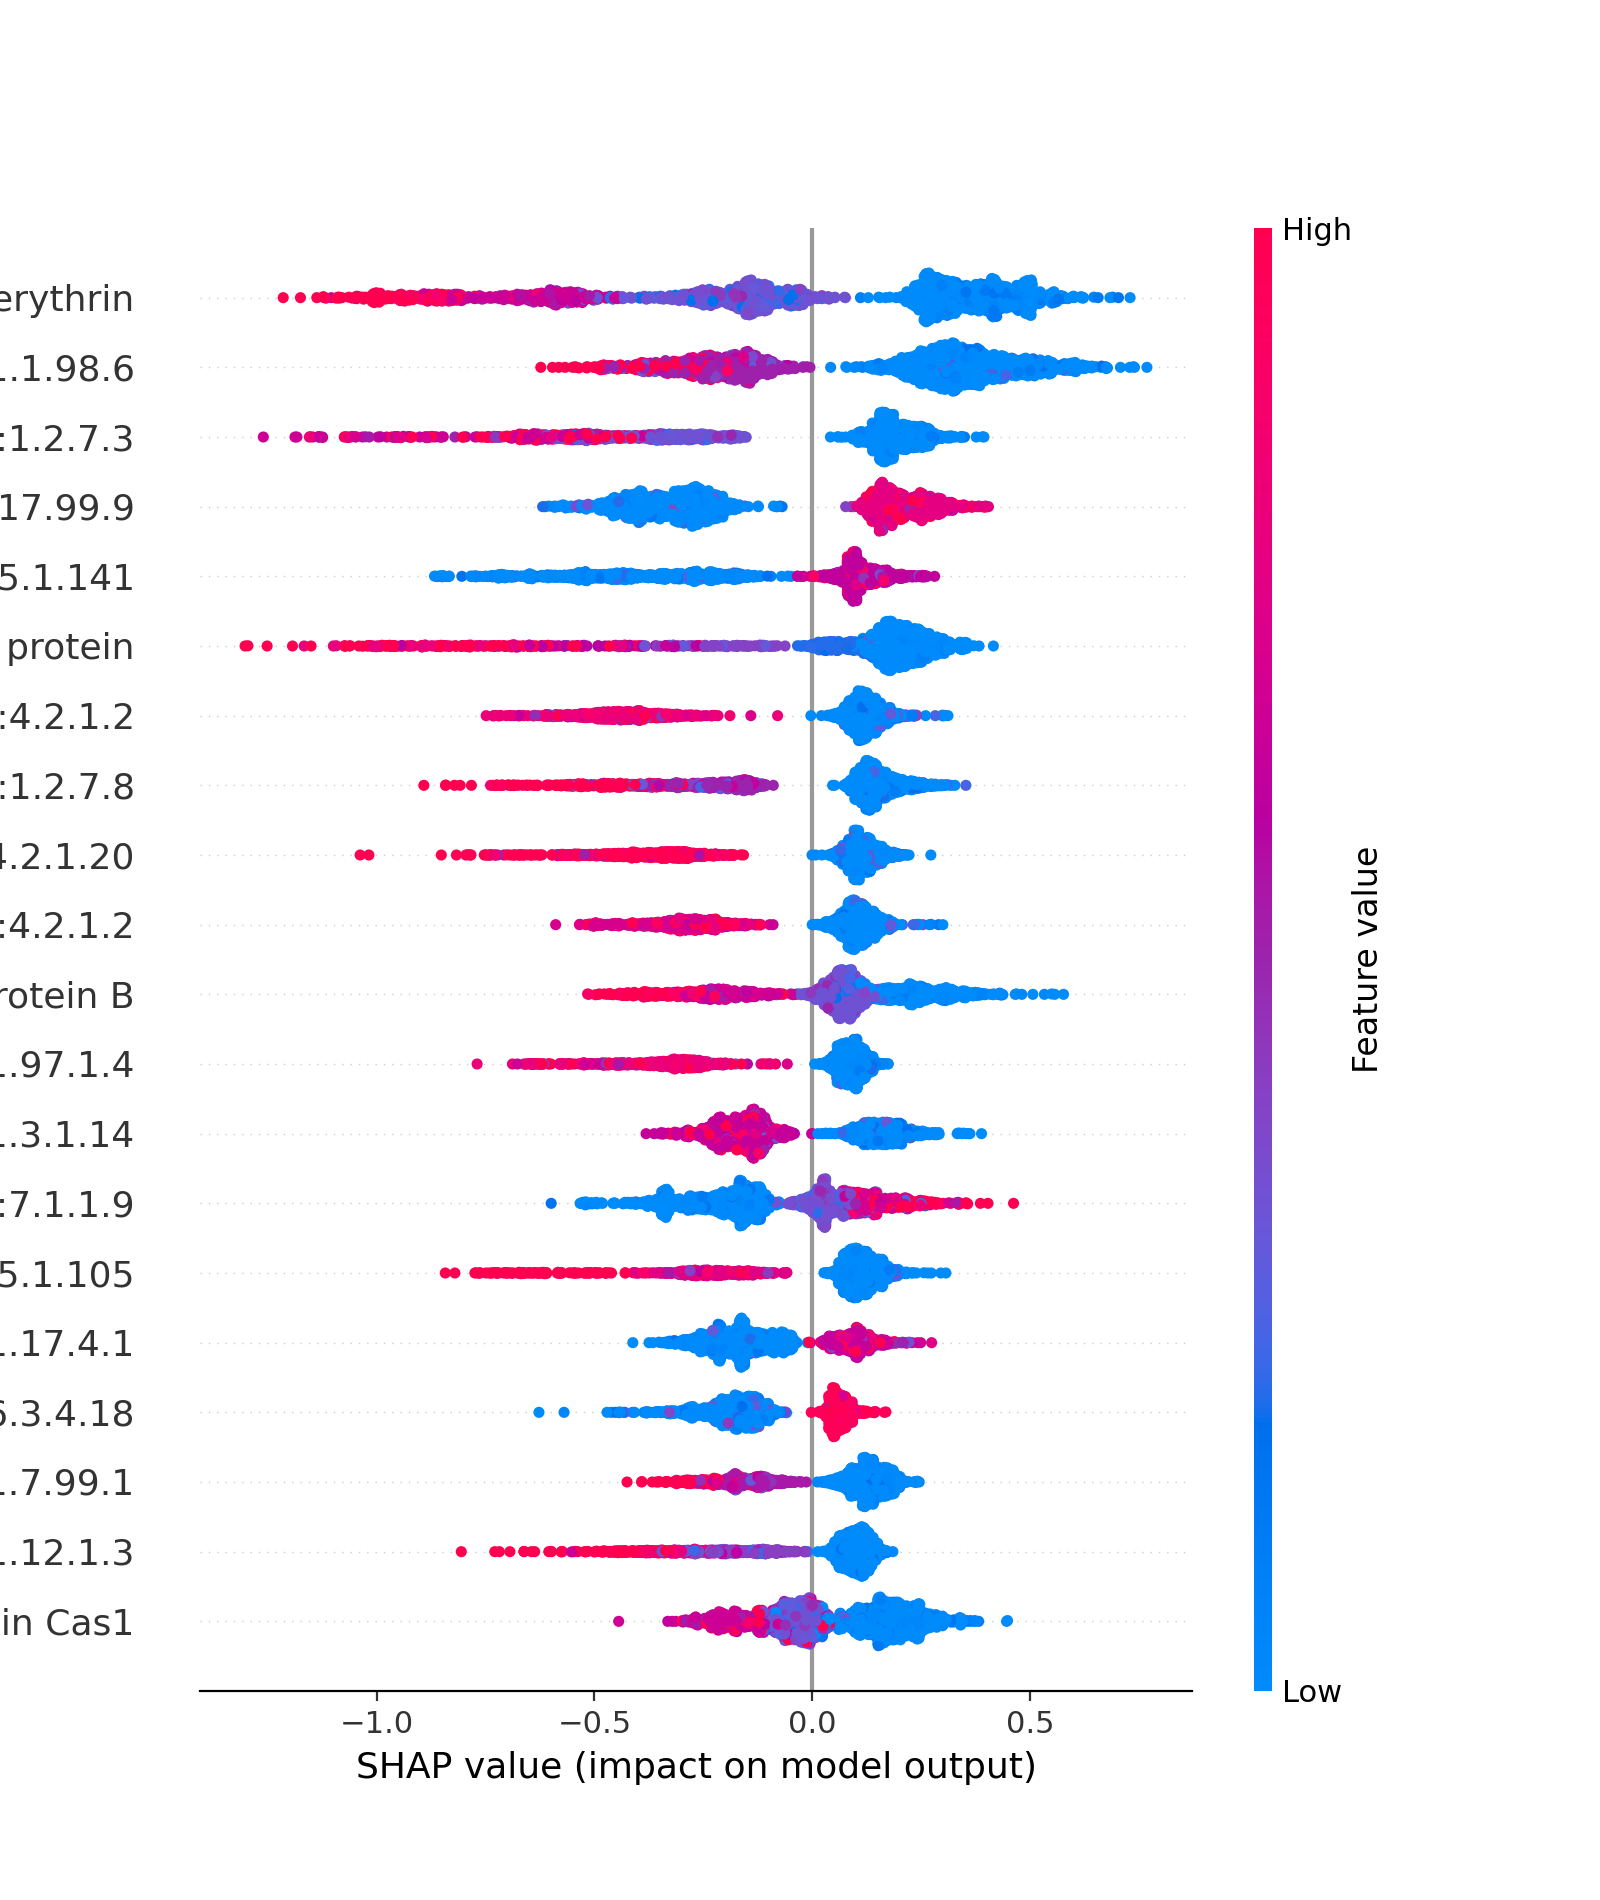

In [70]:
shap.summary_plot(shap_values, X_pred_scaled)

In [71]:
X_pred_scaled.loc[1963,:]

COG0001 K01845 glutamate-1-semialdehyde 2,1-aminomutase EC:5.4.3.8                      0.145455
COG0002 K00145 N-acetyl-gamma-glutamyl-phosphate reductase EC:1.2.1.38                  0.032000
COG0003 K01551 arsenite/tail-anchored protein-transporting ATPase EC:7.3.2.7 7.3.-.-    0.068889
COG0004 K03320 ammonium transporter, Amt family                                         0.090000
COG0005 K00772 5'-methylthioadenosine phosphorylase EC:2.4.2.28                         0.328000
                                                                                          ...   
COG5640 K09640 transmembrane protease serine 9 EC:3.4.21.-                              0.000000
COG5643 K11261 formylmethanofuran dehydrogenase subunit E EC:1.2.7.12                   0.000000
COG5650 K13671 alpha-1,2-mannosyltransferase EC:2.4.1.-                                 0.001000
COG5652 K20950 polysaccharide biosynthesis protein VpsQ                                 0.010000
COG5663 K05967 uncharacterized

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


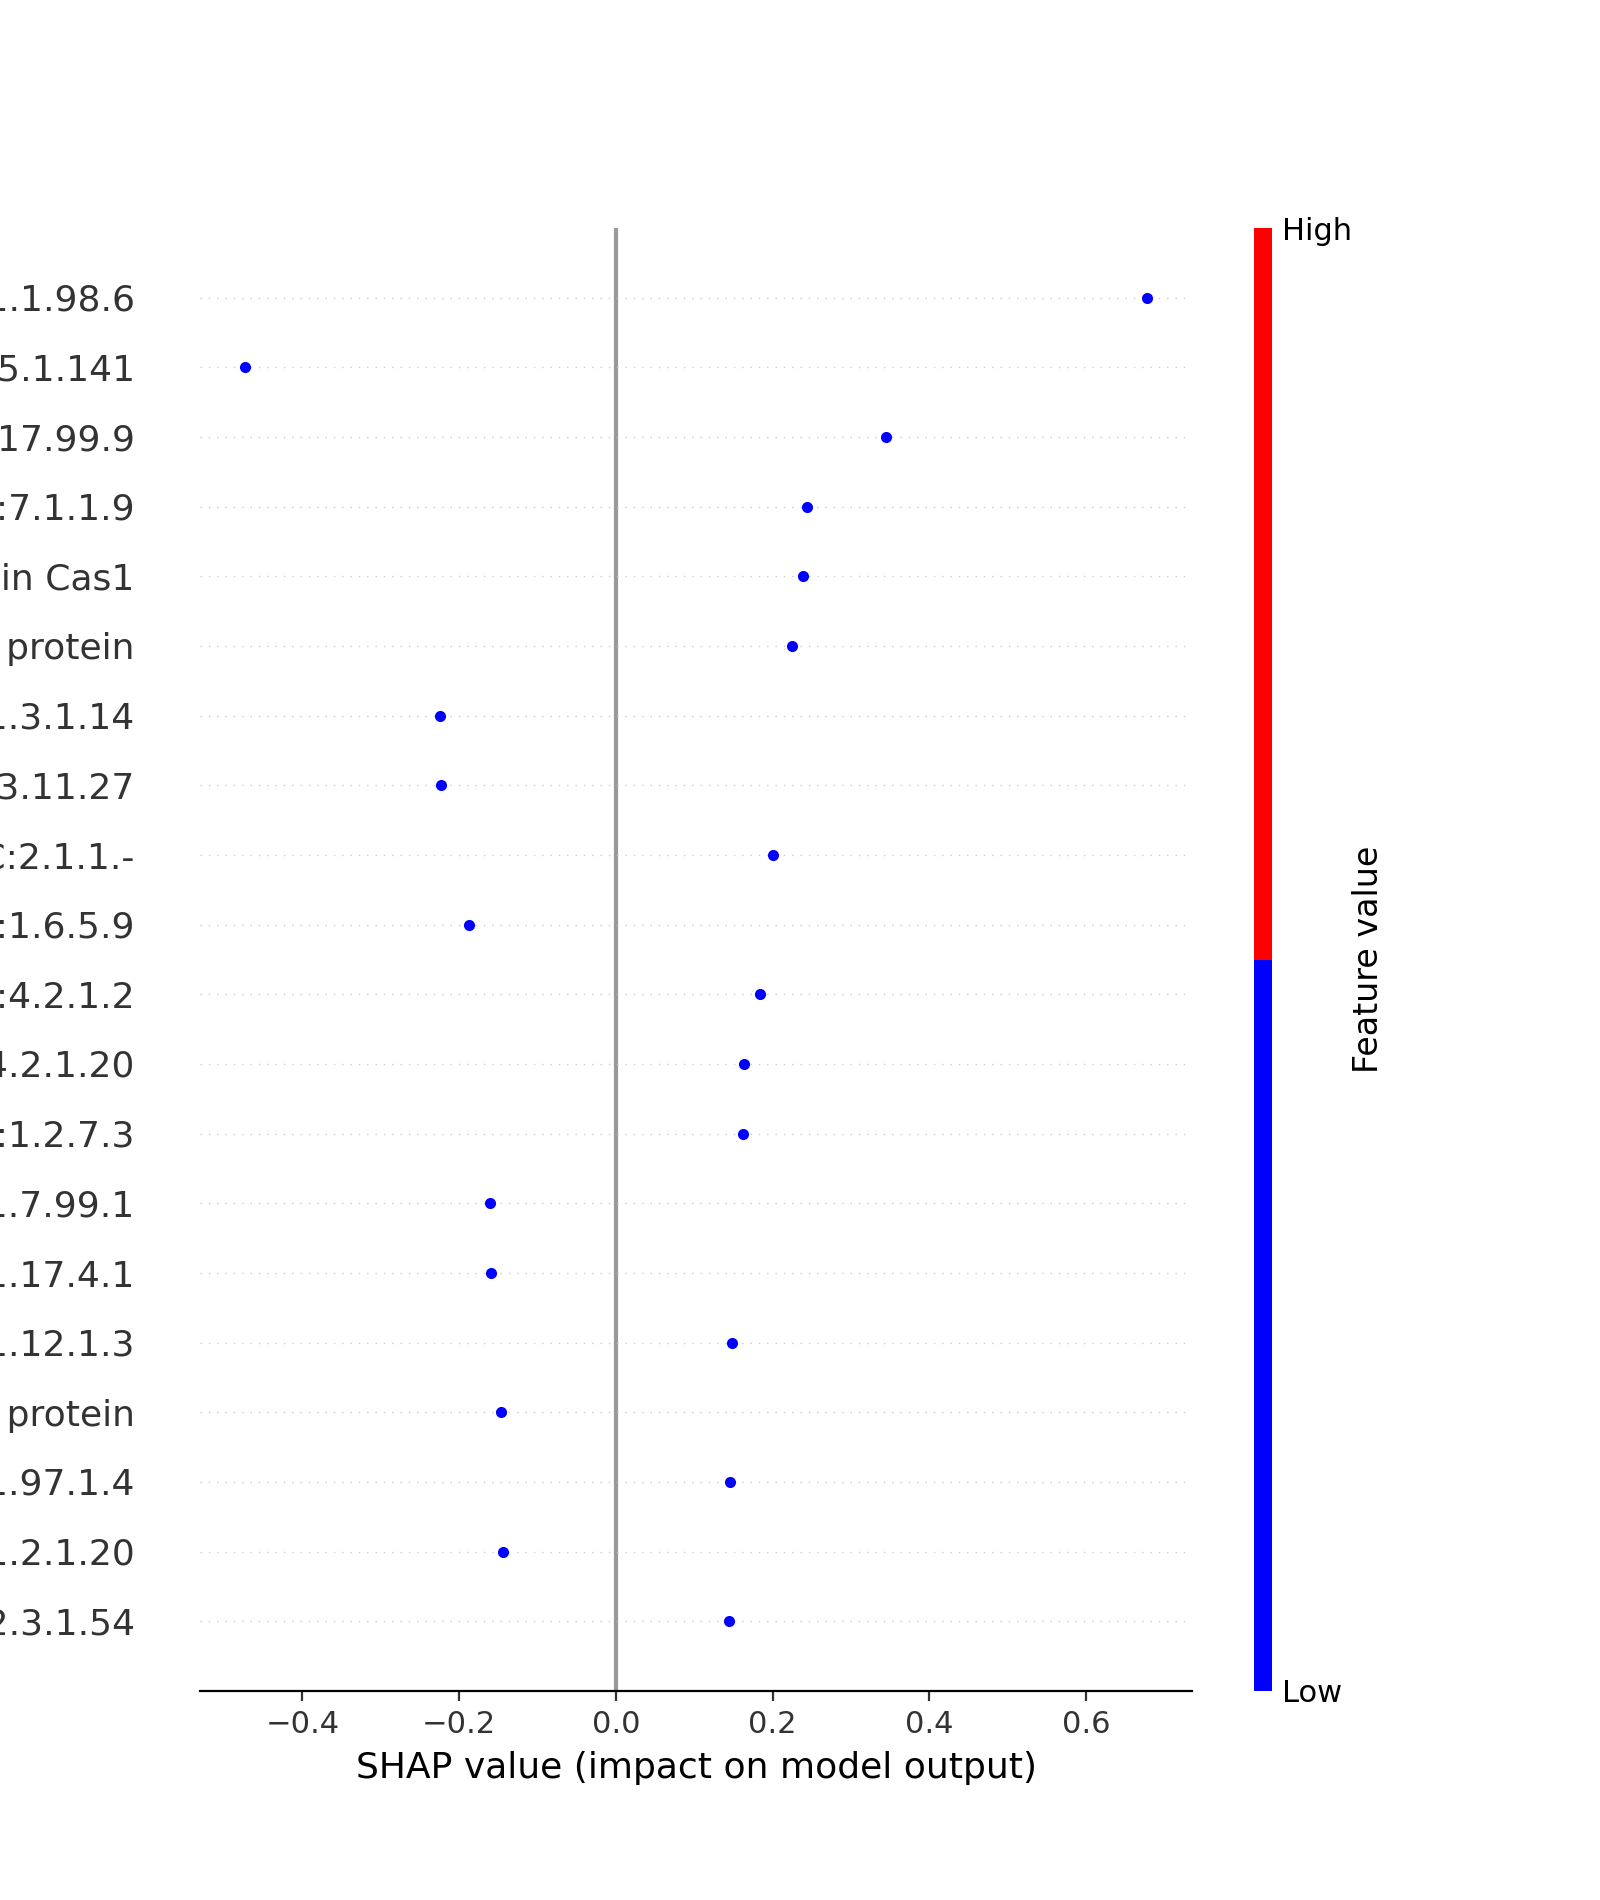

In [72]:
import matplotlib
my_colourmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"], N=2)
shap.summary_plot(shap_values[[1963],:], X_pred_scaled.loc[[1963],:], cmap=my_colourmap)

In [73]:
print([c for c in X_pred_scaled.columns if 'COG0843' in c])
X_pred_scaled.loc[1963,'COG0843 K02274 cytochrome c oxidase subunit I EC:7.1.1.9']
X.loc[1963,'COG0843']
# X

['COG0843 K02274 cytochrome c oxidase subunit I EC:7.1.1.9']


3

# Total set of SHAP values

In [74]:
print(np.abs(shap_values).shape)
aggs = np.abs(shap_values).mean(0)
aggs

(2013, 2672)


array([0.02878117, 0.        , 0.00159735, ..., 0.        , 0.00060983,
       0.        ], dtype=float32)

In [75]:
# Want 
# 1. COG
# 2. COG descriptive name
# 3. mean absolute SHAP value
# 4. mean absolute SHAP for aerobe predictions
# 5. mean absolute SHAP for anaerobe predictions

# preds_and_shaps = pl.concat([
#     pl.DataFrame({
#     'pred': pred,}),
#     pl.DataFrame(shap_values),], how='horizontal')
# preds_and_shaps.columns = ['pred'] + list(X_pred_scaled.columns)

# # preds_and_shaps.groupby('pred').apply(lambda x: pl.Series(np.abs(x).mean(0)))
aerobe_shaps = shap_values[pred==1]
anaerobe_shaps = shap_values[pred==0]
# d5.iloc[pred==1,:].mean(0)
shap_df = pl.DataFrame({
    'cog': list(X.columns),
    'description': list(X_pred_scaled.columns),
    'mean absolute SHAP': aggs,
    'mean aerobe SHAP': aerobe_shaps.mean(0),
    'mean anaerobe SHAP': anaerobe_shaps.mean(0),
    'mean aerobe copy number': d5.iloc[pred==1, :].mean(0),
    'mean anaerobe copy number': d5.iloc[pred==0, :].mean(0),
    'median aerobe copy number': d5.iloc[pred==1, :].median(0),
    'median anaerobe copy number': d5.iloc[pred==0, :].median(0),
})
# sort this polars df by mean absolute SHAP
shap_df = shap_df.sort('mean absolute SHAP', descending=True)
# shap_df.write_csv('data/xgboost_shap_values.csv', separator="\t")
shap_df.head(5)

cog,description,mean absolute SHAP,mean aerobe SHAP,mean anaerobe SHAP,mean aerobe copy number,mean anaerobe copy number,median aerobe copy number,median anaerobe copy number
str,str,f32,f32,f32,f64,f64,f64,f64
"""COG1592""","""COG1592 K19824…",0.382531,0.239496,-0.19903,0.254014,1.219062,0.01,1.0
"""COG1328""","""COG1328 K21636…",0.31368,0.31882,0.008559,0.098498,0.7656,0.0,1.0
"""COG1014""","""COG1014 K00177…",0.303175,0.167736,-0.241935,0.065872,1.228922,0.0,1.0
"""COG1612""","""COG1612 K02259…",0.280501,0.092665,-0.269761,0.906032,0.127914,1.0,0.0
"""COG0109""","""COG0109 K02257…",0.254237,0.054919,-0.28493,1.005849,0.278484,1.0,0.0


# Total set of SHAP values for ancestral predictions

In [76]:
all_shaps = pl.DataFrame(shap_values)
all_shaps.columns = X_pred_scaled.columns
all_shaps = all_shaps.select(
    pl.lit(list(d5.index)).alias('node'),
    pl.lit(pred).alias('xgboost_pred'),
    pl.col('*')
)
# all_shaps.write_csv('data/all_ancestral_xgboost_shap_values.tsv', separator="\t")

import gzip
with gzip.open('data/all_ancestral_xgboost_copy_numbers.tsv.gz','wb') as f:
    pl.DataFrame(d5).write_csv(f, separator="\t")

# SHAP values over time

In [77]:
# This file was copied in directly.
ages = pl.read_csv('data/MasterChronograms.tsv', separator="\t", has_header=True)

# sorted(list(ages_shaps['node']))[-5:]
# sorted(list(ages_shaps['node']))[:5]
# all_shaps.shape, ages.shape
ages.filter(pl.col('BranchName')=='1963')

Index,Name,Mean,Variance,Min,Max,95CILower,95CIUpper,Condition,CorrectIndex,BranchName,PlastidNode,Parent,BranchAge,BranchHalfAge,RED,Group,Size,Taxa,Aerotype_XGBoost,Aerotype_ExtraTrees,XGBoost,XGBoost_prob,ExtraTrees,ExtraTrees_prob,ConcatenateValue,ConcatenatePrediction,Annotation
i64,str,f64,f64,f64,f64,f64,f64,str,str,str,bool,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str
1216,"""1215""",2642.556281,85845.018247,1857.861197,3578.035572,2134.193883,3205.937672,"""No""","""1216""","""1963""",false,"""1970""","""2642.556280585…",2724.939274,0.705468,"""NAN""","""41""","""NAN""","""01""","""01""","""1""","""0.974153935909…","""1""","""0.69""","""-1.06297111062…","""0""","""NAN"""
1216,"""1215""",3298.904411,4090.416911,3224.962614,3660.708855,3227.678375,3464.463466,"""Simple""","""1216""","""1963""",false,"""1970""","""3298.904411370…",3381.55753,0.705468,"""NAN""","""41""","""NAN""","""01""","""01""","""1""","""0.974153935909…","""1""","""0.69""","""-1.06297111062…","""0""","""NAN"""
1216,"""1215""",3232.404463,53.898306,3224.921502,3280.726309,3225.154804,3252.072954,"""Full""","""1216""","""1963""",false,"""1970""","""3232.404463463…",3306.066212,0.705468,"""NAN""","""41""","""NAN""","""01""","""01""","""1""","""0.974153935909…","""1""","""0.69""","""-1.06297111062…","""0""","""NAN"""
1216,"""1215""",3232.546467,53.509406,3224.896841,3288.672899,3225.158166,3251.791827,"""ExtraTrees""","""1216""","""1963""",false,"""1970""","""3232.546466795…",3308.729568,0.705468,"""NAN""","""41""","""NAN""","""01""","""01""","""1""","""0.974153935909…","""1""","""0.69""","""-1.06297111062…","""0""","""NAN"""
1216,"""1215""",3276.321916,2298.497469,3224.986781,3648.720657,3226.421937,3402.709287,"""Concatenate""","""1216""","""1963""",false,"""1970""","""3276.321916379…",3349.668084,0.705468,"""NAN""","""41""","""NAN""","""01""","""01""","""1""","""0.974153935909…","""1""","""0.69""","""-1.06297111062…","""0""","""NAN"""


In [78]:
all_shaps.select([pl.col('node').str.replace(r'\(.*','')])
ages_shaps = ages.filter(pl.col('Condition')=='Full').select([pl.col('BranchName').alias('node'),pl.col('Mean').alias('age')]).join(all_shaps.select([pl.col('node').str.replace(r'\(.*','')], pl.exclude('node')), on='node', how='inner')

In [79]:
ages_shaps = ages_shaps.sort(pl.col('node'))
d5s = pl.DataFrame(d5)
d5s = d5s.select([
    pl.lit(list(d5.index)).alias('node'),
    pl.col('*')
])
d5s = d5s.sort(pl.col('node'))
d5s = d5s.with_columns(pl.lit(ages_shaps['age']).alias('age'))
d5s = d5s.select(['node','age',pl.exclude(['node','age'])])
d5s.columns = ['node','age'] + list(X_pred_scaled.columns)
print(ages_shaps[:3], d5s[:3])

shape: (3, 2_675)
┌──────┬─────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ node ┆ age     ┆ xgboost_pr ┆ COG0001    ┆ … ┆ COG5643    ┆ COG5650    ┆ COG5652    ┆ COG5663    │
│ ---  ┆ ---     ┆ ed         ┆ K01845 glu ┆   ┆ K11261 for ┆ K13671 alp ┆ K20950 pol ┆ K05967 unc │
│ str  ┆ f64     ┆ ---        ┆ tamate-1-s ┆   ┆ mylmethano ┆ ha-1,2-man ┆ ysaccharid ┆ haracteriz │
│      ┆         ┆ i64        ┆ emia…      ┆   ┆ fura…      ┆ nosy…      ┆ e bi…      ┆ ed p…      │
│      ┆         ┆            ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│      ┆         ┆            ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞══════╪═════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 1007 ┆ 781.837 ┆ 0          ┆ -0.003279  ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.000518   ┆ 0.0        │
│      ┆ 948     ┆            ┆            ┆   ┆            ┆            

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


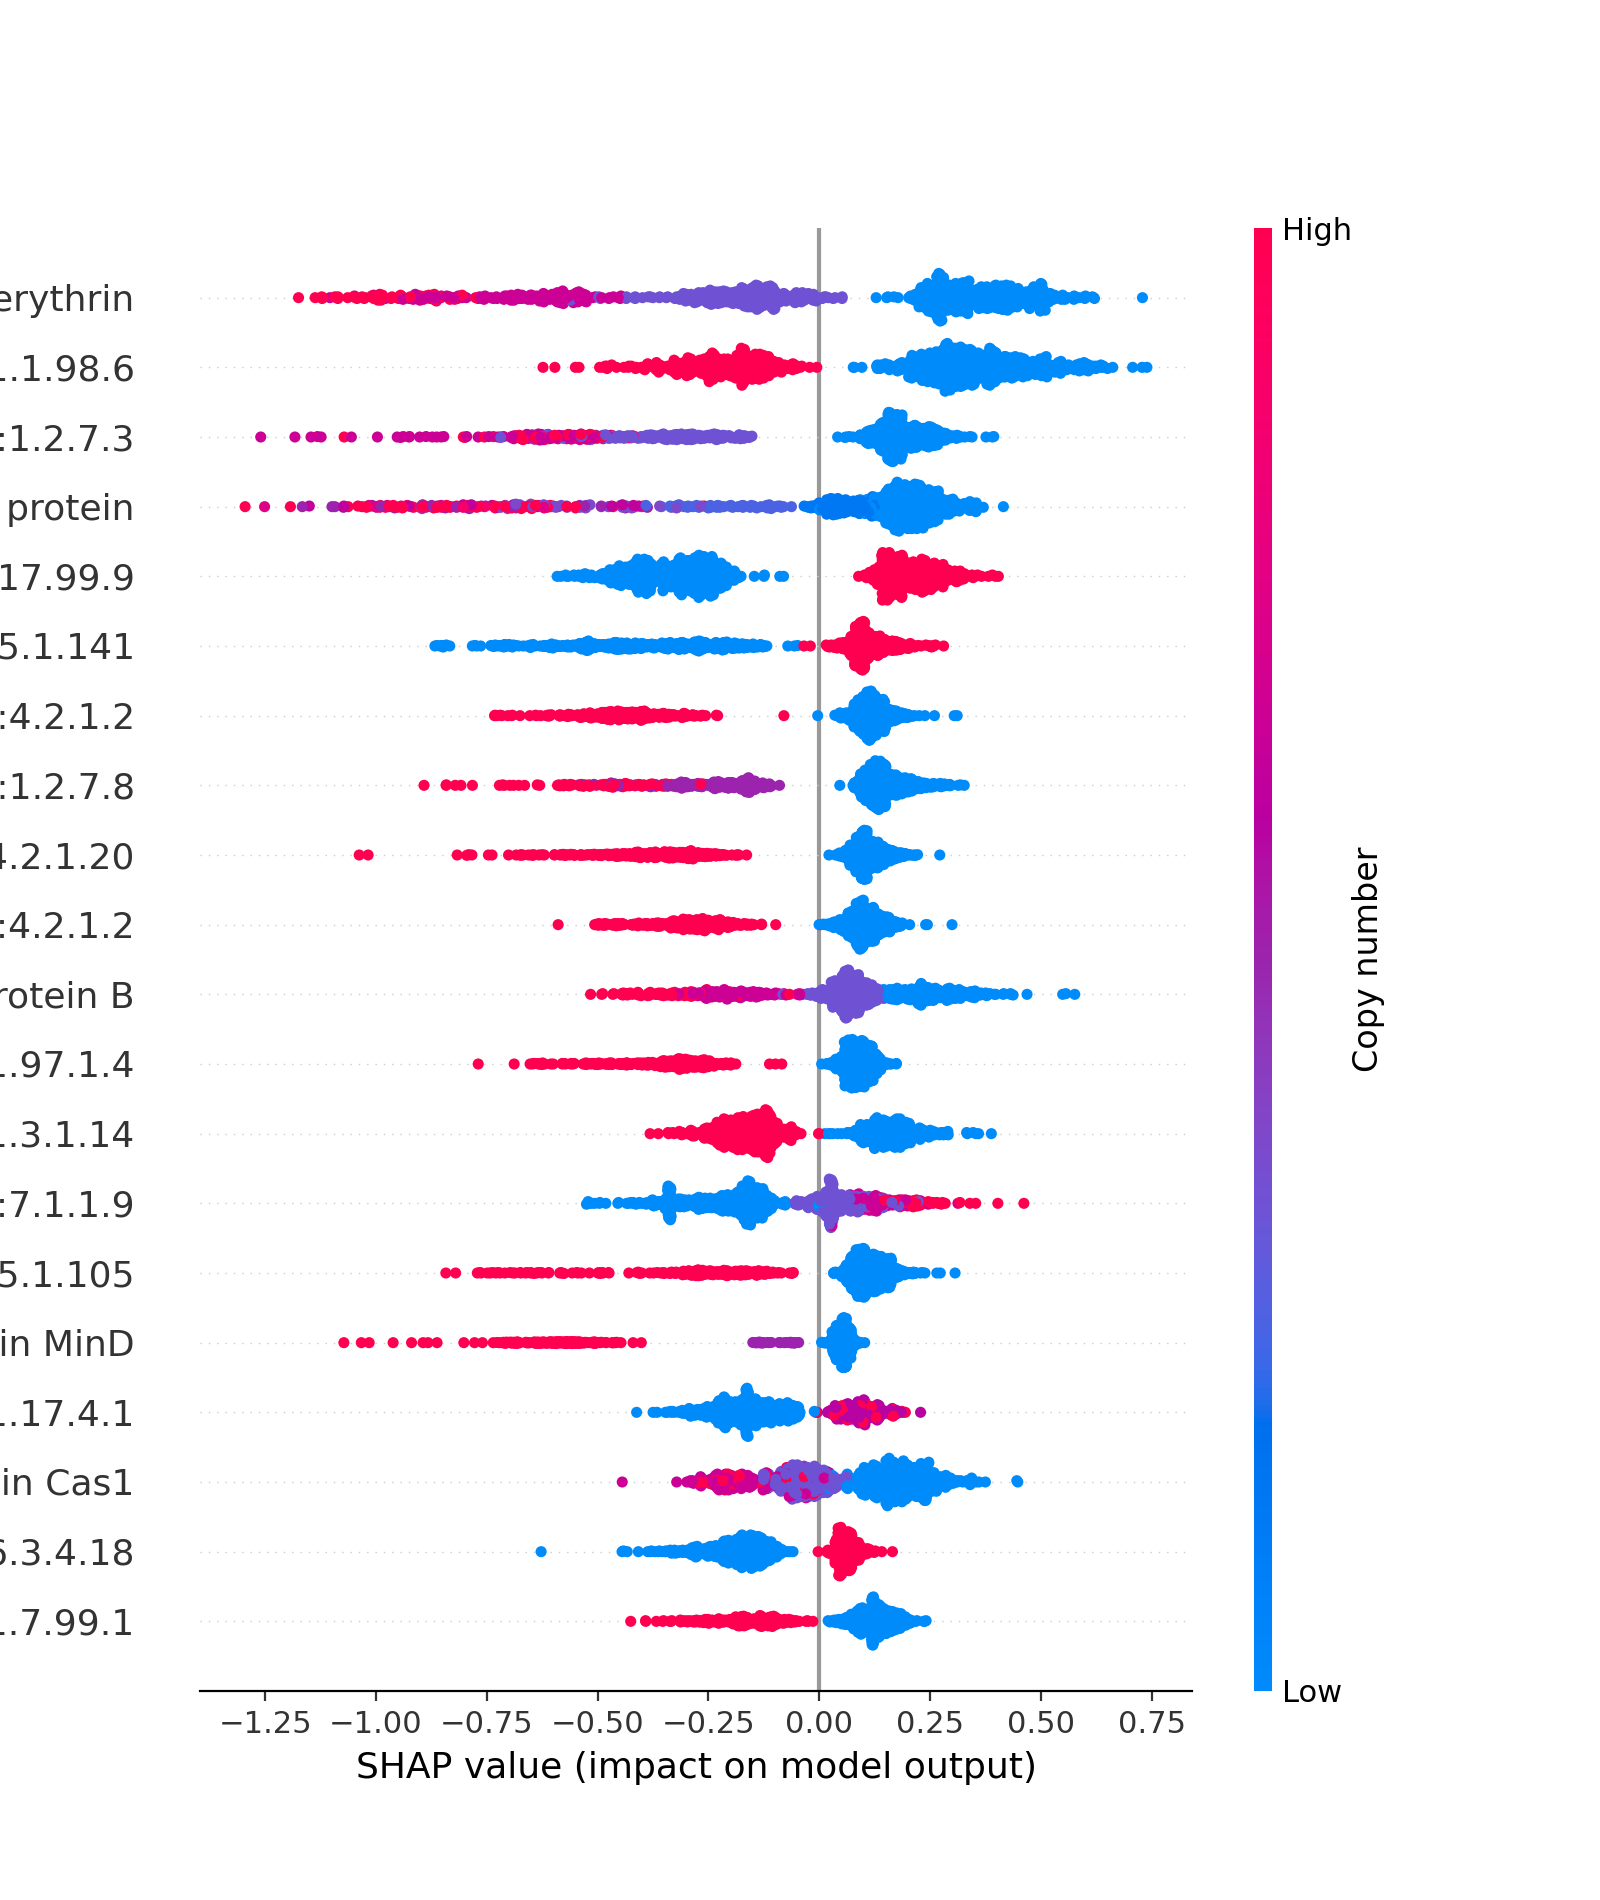

In [80]:
shap.summary_plot(
    ages_shaps.filter(pl.col('age')==0).select(pl.exclude(['node','age','xgboost_pred'])).to_numpy(),
    d5s.filter(pl.col('age')==0).select(pl.exclude(['node','age'])).to_pandas(),
    color_bar_label='Copy number')
# shap.summary_plot(ages_shaps.select(pl.exclude(['node','age']))[tip_indexes,:], d5s.select(pl.exclude('node'))[tip_indexes,:])

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


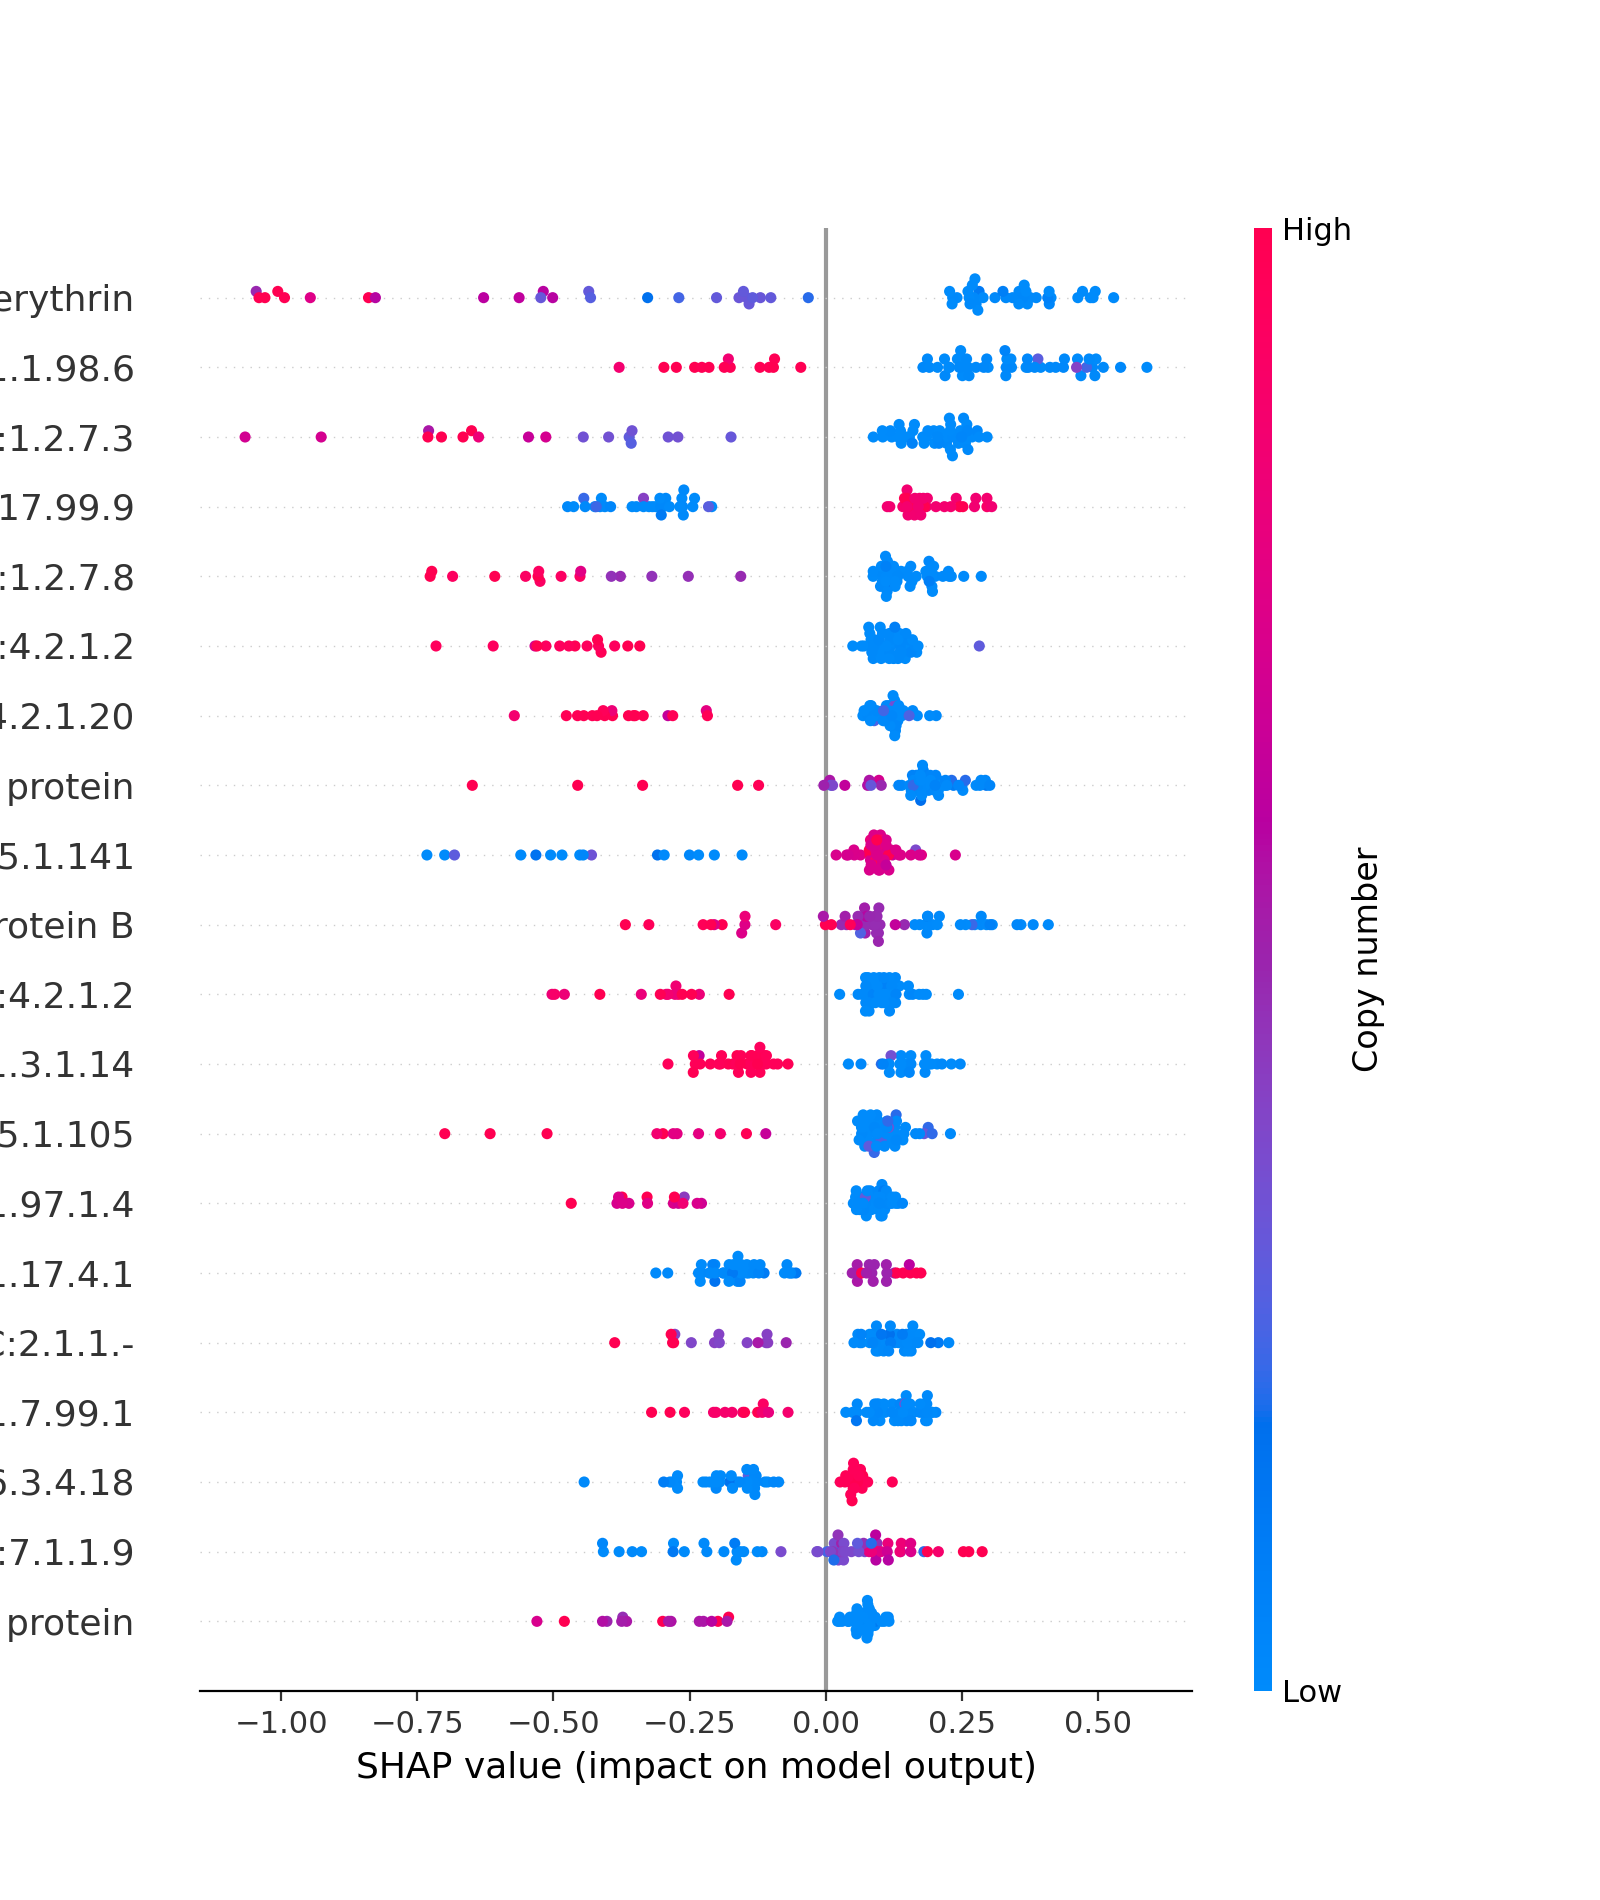

In [81]:
min_age, max_age = 1, 500
shap.summary_plot(
    ages_shaps.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age','xgboost_pred'])).to_numpy(),
    d5s.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age'])).to_pandas(),
    color_bar_label='Copy number')

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


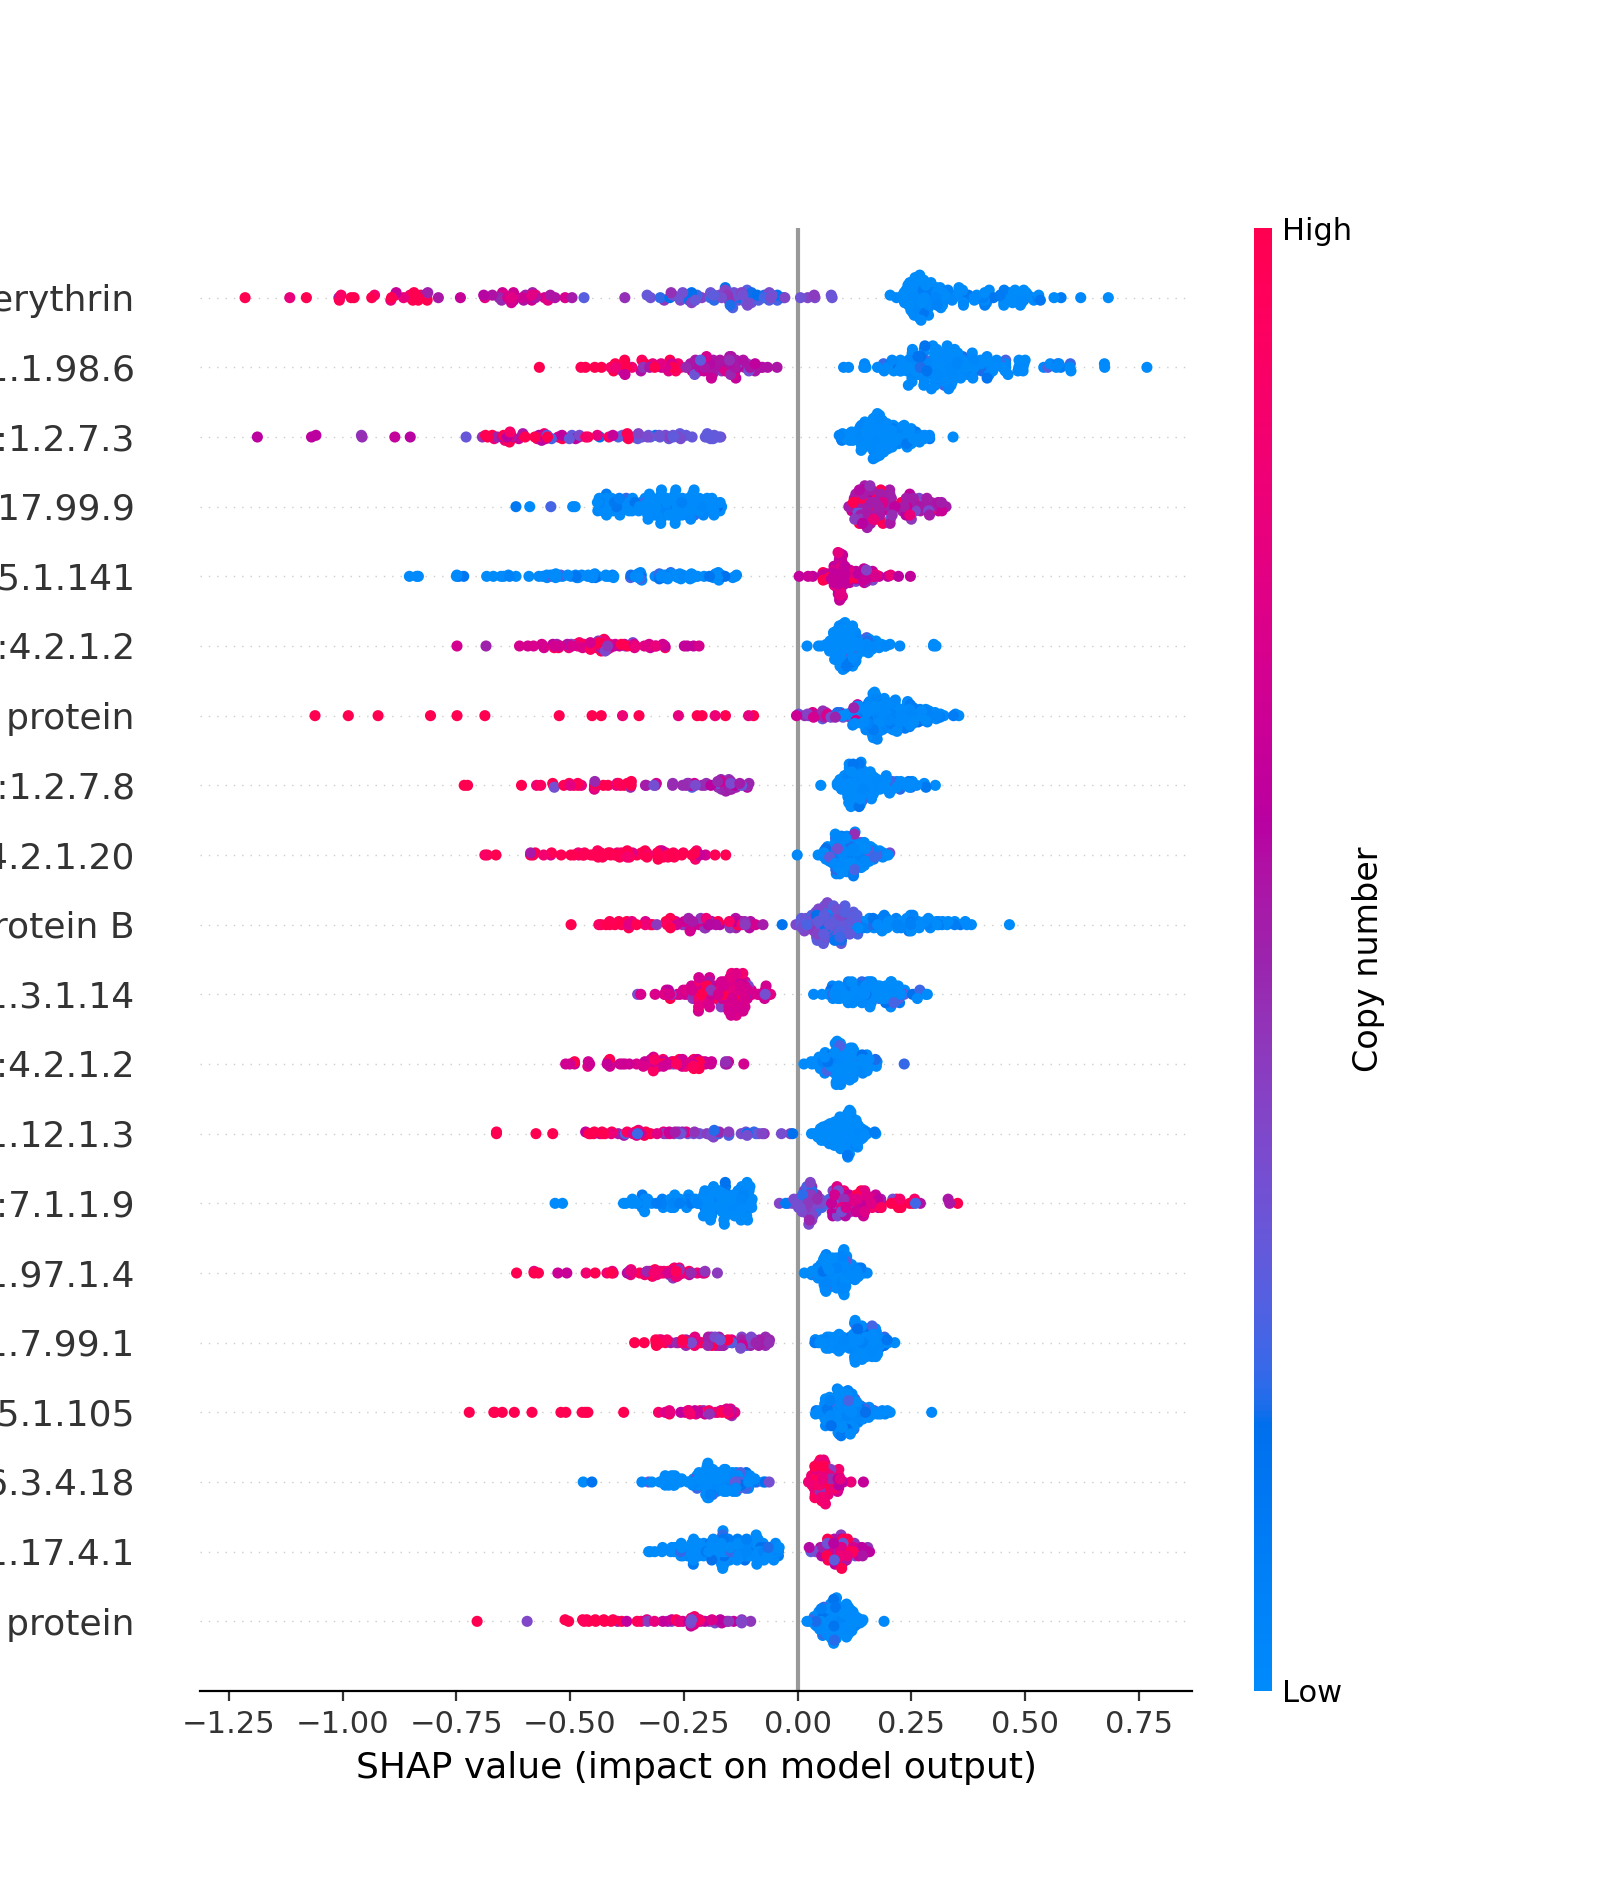

In [82]:
min_age, max_age = 500, 1000
shap.summary_plot(
    ages_shaps.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age','xgboost_pred'])).to_numpy(),
    d5s.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age'])).to_pandas(),
    color_bar_label='Copy number')

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


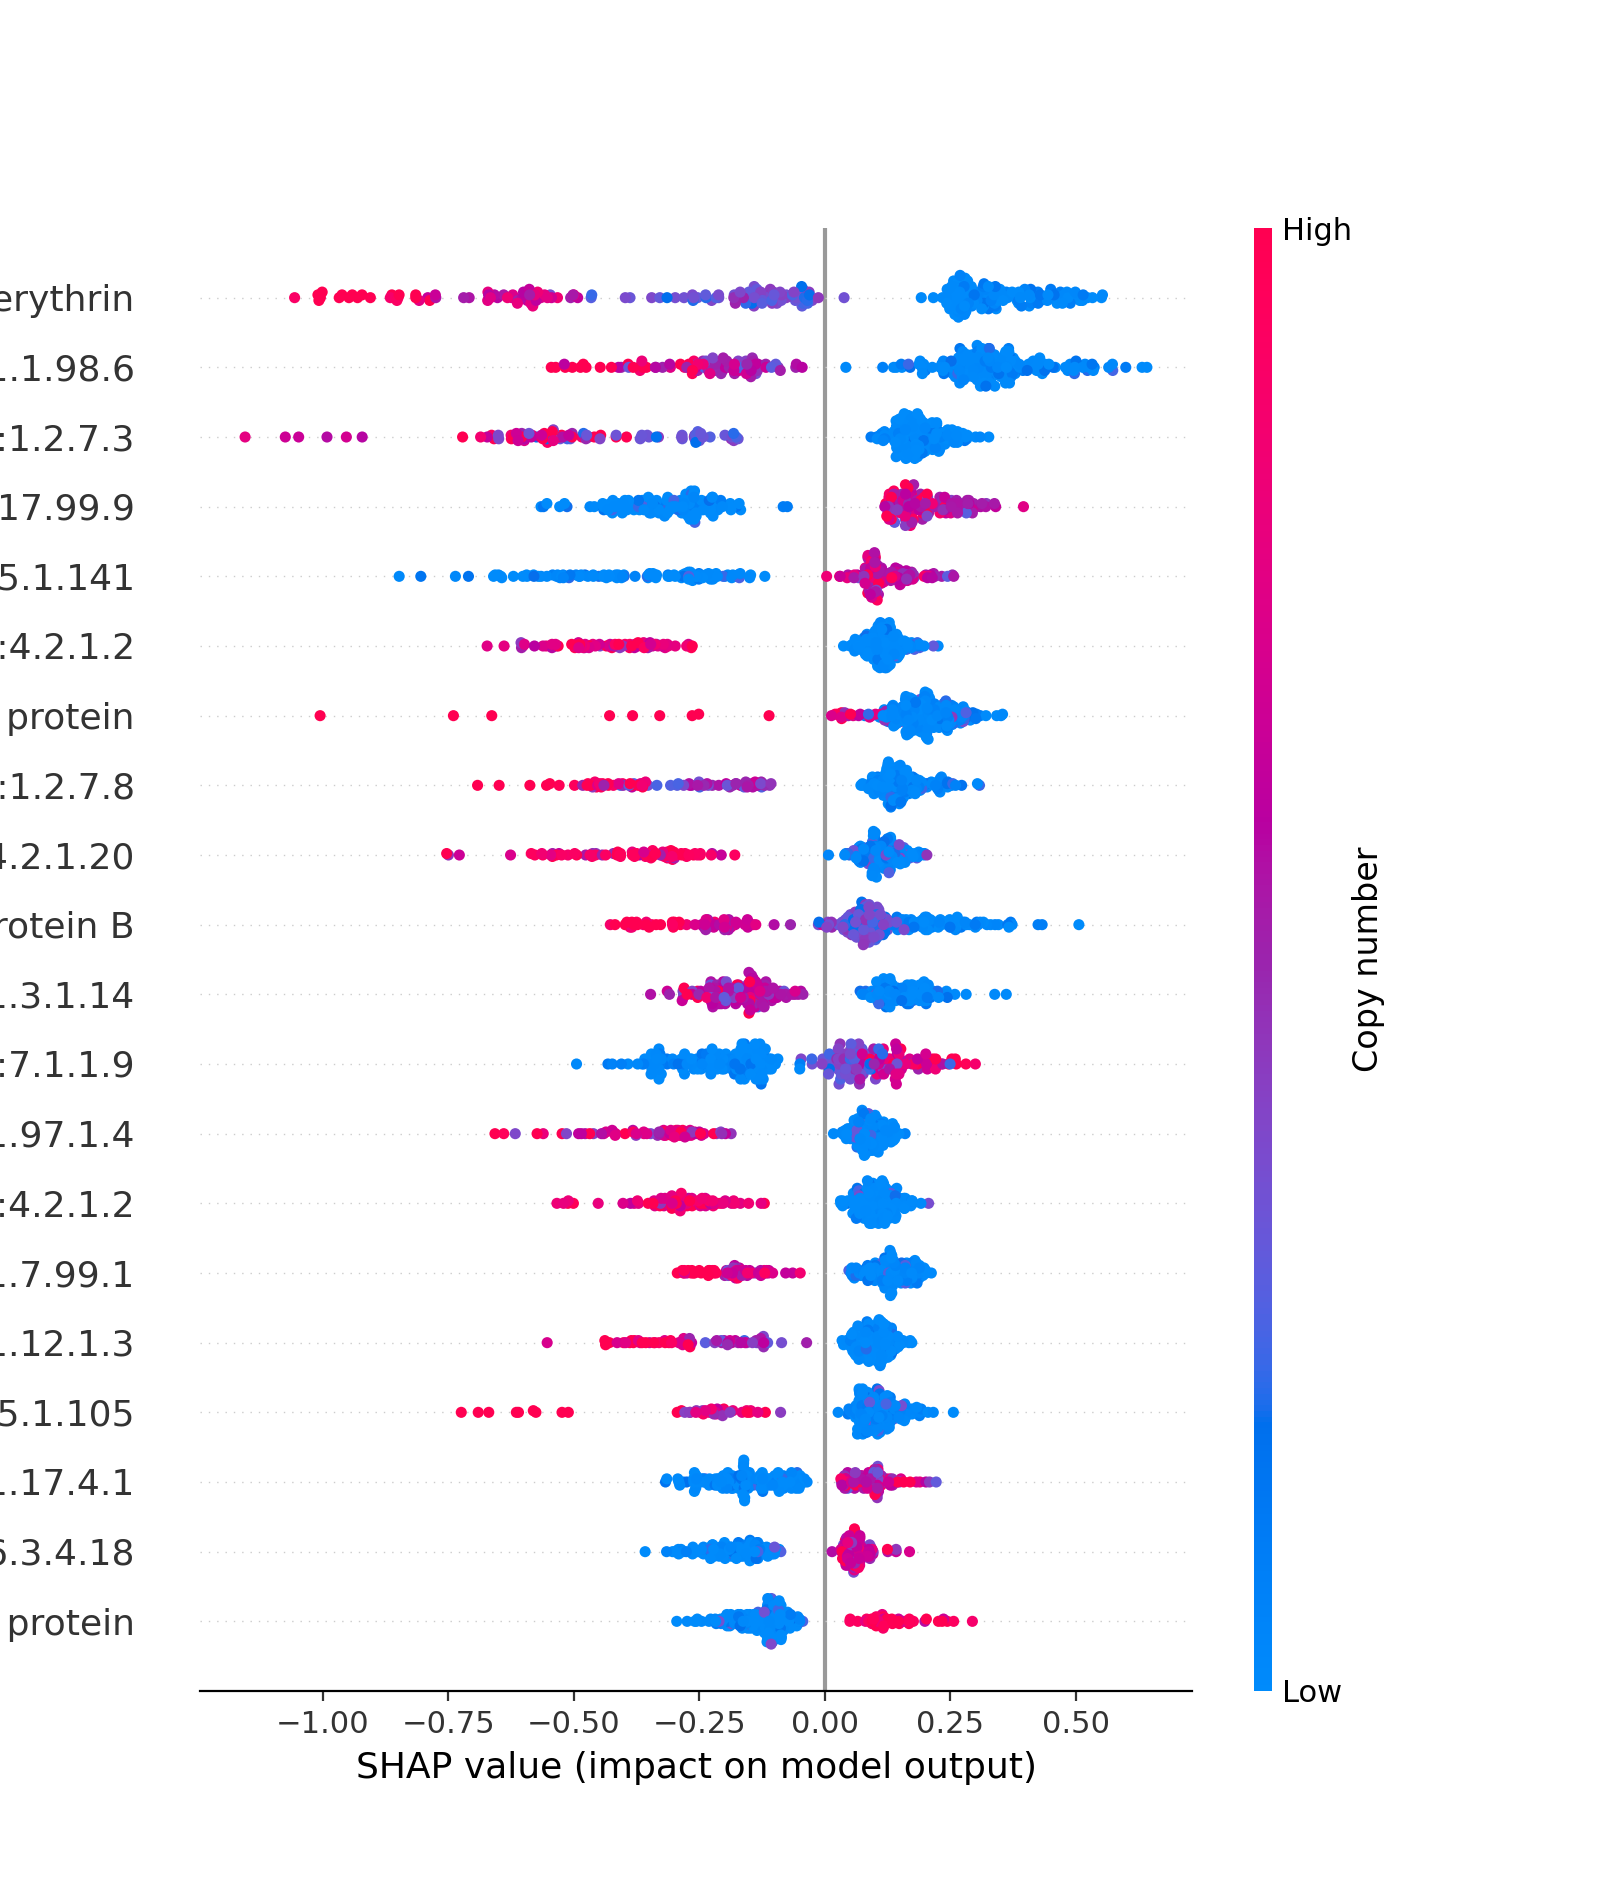

In [83]:
min_age, max_age = 1000, 1500
shap.summary_plot(
    ages_shaps.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age','xgboost_pred'])).to_numpy(),
    d5s.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age'])).to_pandas(),
    color_bar_label='Copy number')

/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/woodcrob/e/mybase7/lib/python3.11/site-packages/shap/plots/_beeswarm.py:890: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


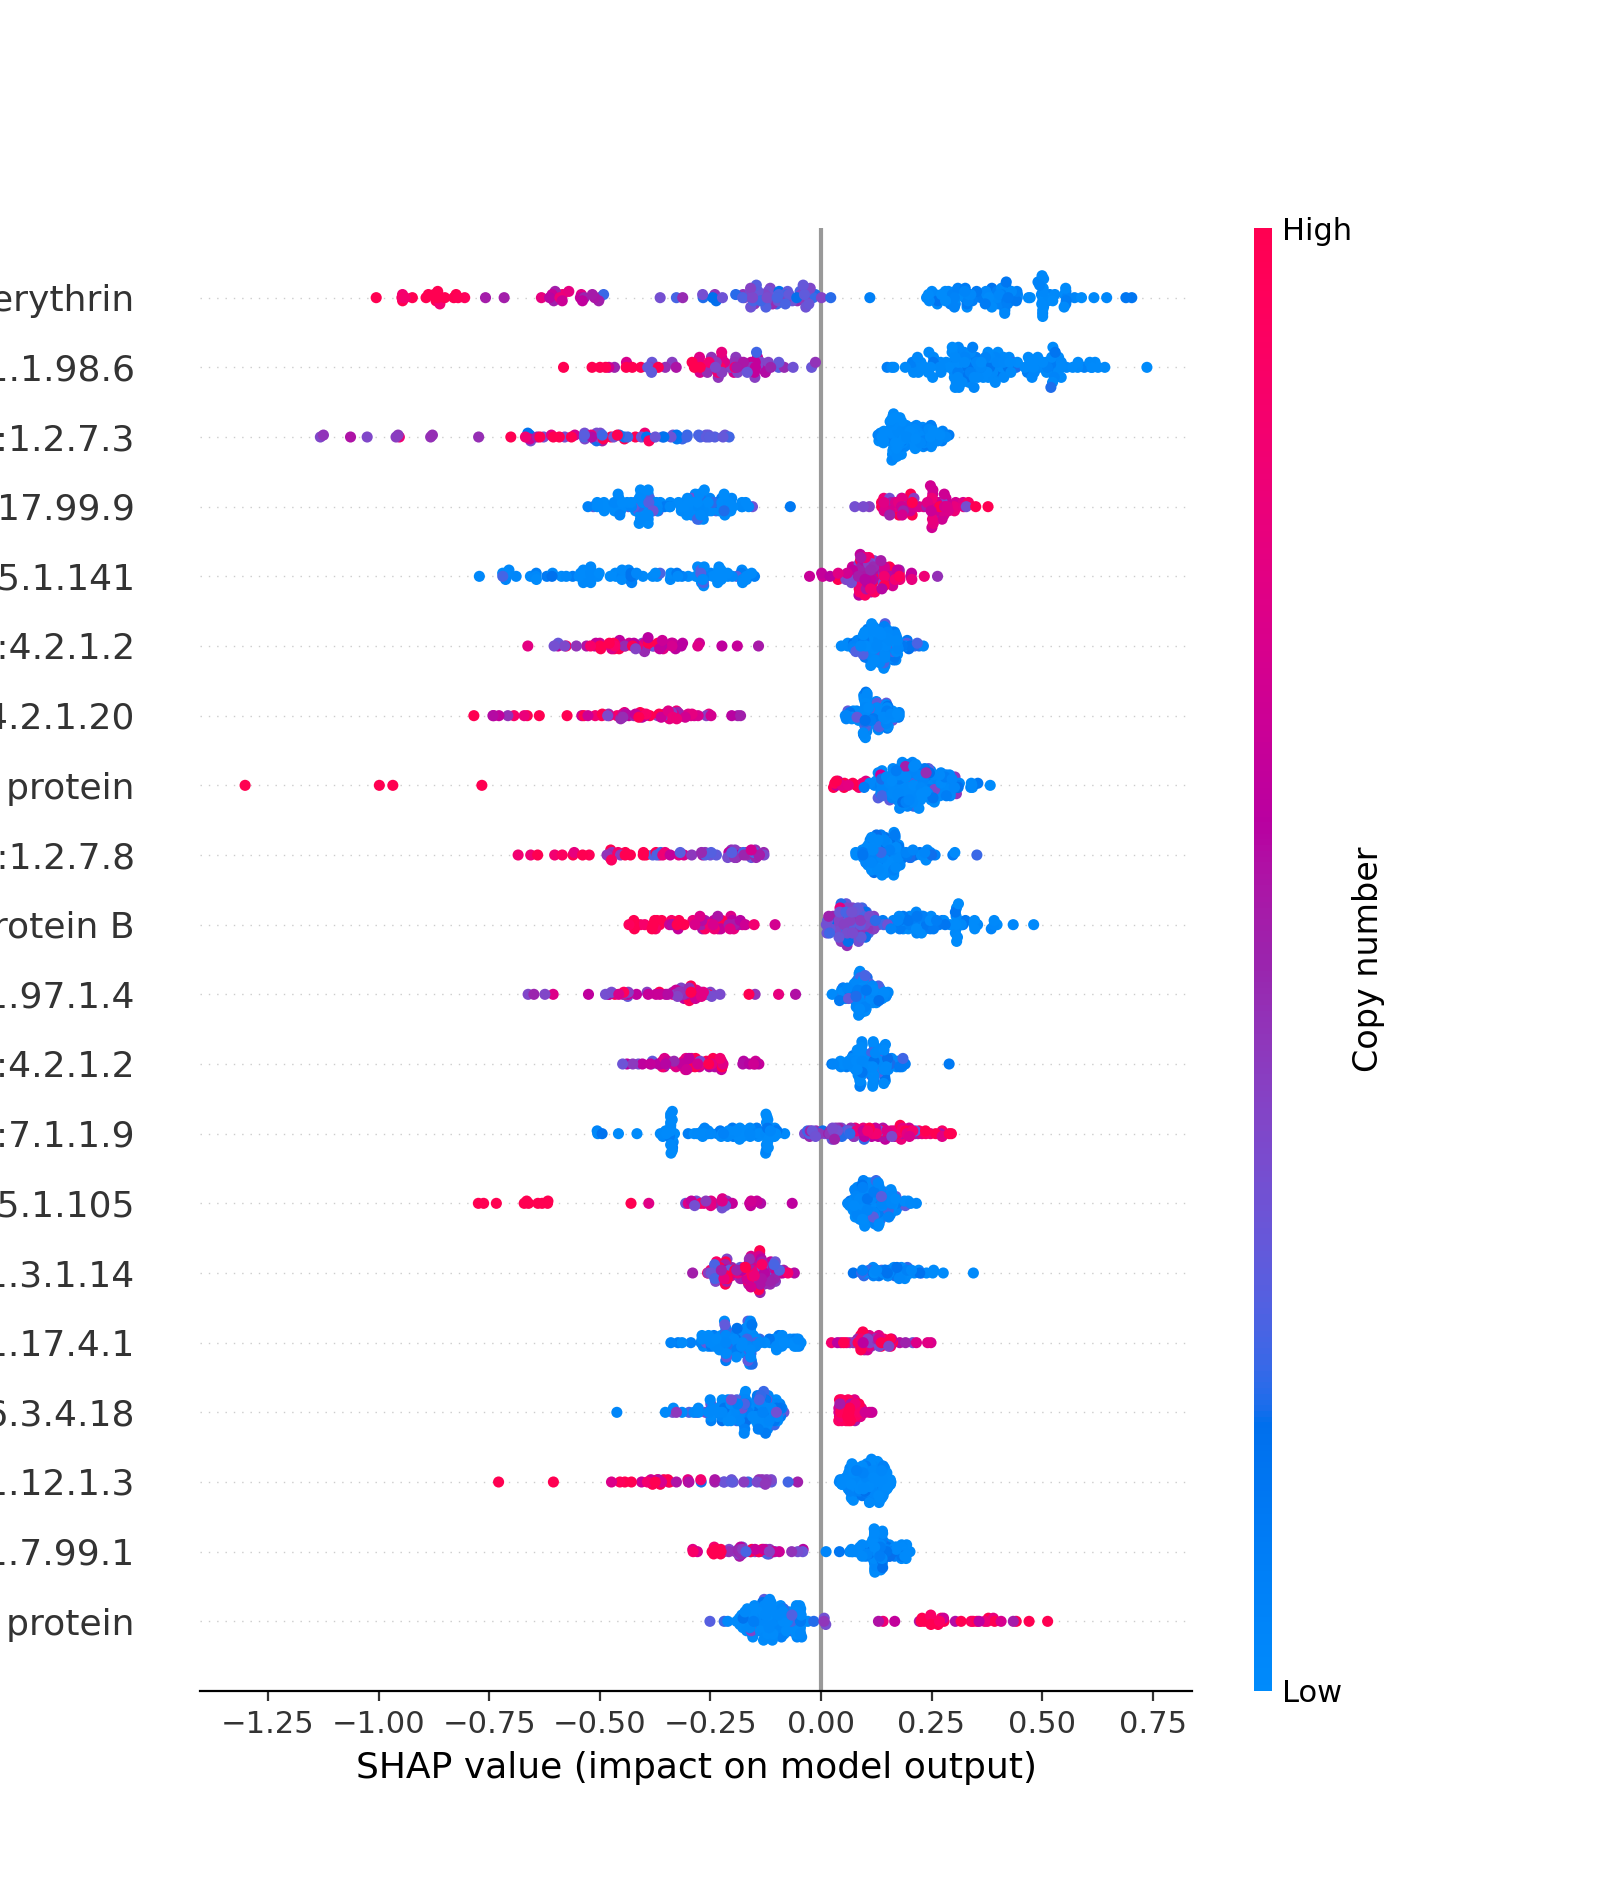

In [84]:
min_age, max_age = 1500, 2000
shap.summary_plot(
    ages_shaps.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age','xgboost_pred'])).to_numpy(),
    d5s.filter(pl.col('age')>min_age).filter(pl.col('age')<max_age).select(pl.exclude(['node','age'])).to_pandas(),
    color_bar_label='Copy number')